In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
sys.path.append('../src')
from fantasy_stats_from_pbp import *
from retreive_adp_data import *
import pymc as pm
import arviz as az
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# read in df from nfl fast R data collected
pbp = pd.read_pickle('../data/raw/nfl_pbp_data.pkl')
pbp.head()

aborted_play  air_epa  air_wpa  air_yards  assist_tackle  \
0             0      NaN      NaN        NaN            0.0   
1             0      NaN      NaN        NaN            0.0   
2             0      NaN      NaN        NaN            0.0   
3             0      NaN      NaN        NaN            0.0   
4             0      NaN      NaN        NaN            0.0   

  assist_tackle_1_player_id assist_tackle_1_player_name assist_tackle_1_team  \
0                       NaN                         NaN                  NaN   
1                       NaN                         NaN                  NaN   
2                       NaN                         NaN                  NaN   
3                       NaN                         NaN                  NaN   
4                       NaN                         NaN                  NaN   

  assist_tackle_2_player_id assist_tackle_2_player_name  ... xyac_success  \
0                       NaN                         NaN  ...          NaN   
1                       NaN                         NaN  ...          NaN   
2                       NaN                         NaN  ...          NaN   
3                       NaN                         NaN  ...          NaN   
4                       NaN                         NaN  ...          NaN   

  yac_epa yac_wpa yardline_100 yards_after_catch yards_gained ydsnet ydstogo  \
0     NaN     NaN         30.0               NaN          0.0    6.0       0   
1     NaN     NaN         77.0               NaN          0.0    6.0      10   
2     NaN     NaN         77.0               NaN          1.0    6.0      10   
3     NaN     NaN         76.0               NaN          0.0    6.0       9   
4     NaN     NaN         81.0               NaN         10.0    6.0      14   

   year   yrdln  
0  1999  ARI 30  
1  1999  PHI 23  
2  1999  PHI 23  
3  1999  PHI 24  
4  1999  PHI 19  

[5 rows x 373 columns]

In [3]:
josh_allen_id = '00-0034857'
josh_allen_stats = create_player_stats(josh_allen_id, pbp)
josh_allen_stats['fantasy_pts'] = josh_allen_stats.apply(lambda row: calculate_espn_ppr_score(row), axis=1)
josh_allen_stats

c:\Users\irela\Documents\NSS_Projects\ff-draft-optimizer\notebooks\../src\fantasy_stats_from_pbp.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pbp['two_pt'] = np.where((pbp['two_point_conv_result']=='success'), 1, 0)


id  reception  passing_yards  pass_touchdown  rush_touchdown  \
season                                                                         
2018    00-0034857          0         2044.0            10.0             8.0   
2019    00-0034857          0         3089.0            20.0             9.0   
2020    00-0034857          1         4544.0            37.0             8.0   
2021    00-0034857          0         4168.0            34.0             6.0   
2022    00-0034857          0         4029.0            32.0             7.0   
2023    00-0034857          0         3947.0            27.0            15.0   
2024    00-0034857          0         3731.0            28.0            12.0   

        interception  fumble_lost  rushing_yards  two_pt  receiving_yards  \
season                                                                      
2018            12.0          2.0          631.0     1.0              0.0   
2019             9.0          4.0          510.0     3.0              0.0   
2020            10.0          6.0          421.0     0.0             12.0   
2021            15.0          3.0          700.0     3.0              0.0   
2022            13.0          5.0          746.0     2.0              0.0   
2023            16.0          3.0          457.0     3.0              0.0   
2024             6.0          2.0          531.0     1.0              0.0   

        receive_touchdown  fantasy_pts  
season                                  
2018                  0.0       206.86  
2019                  0.0       288.56  
2020                  1.0       396.06  
2021                  0.0       378.72  
2022                  0.0       373.76  
2023                  0.0       369.58  
2024                  0.0       372.34

In [4]:
#all_players = calculate_all_players_season_stats(save_to_csv=True, csv_filepath='../data/processed/season_stats_05_17.csv')
all_players = pd.read_csv('../data/processed/season_stats_05_17.csv')
rosters = pd.read_csv('../data/raw/rosters.csv', index_col=0).reset_index(drop=True)
all_players = pd.merge(all_players, rosters, how='left', left_on=['id', 'season'], right_on=['gsis_id', 'season'])
all_players.head()

C:\Users\irela\AppData\Local\Temp\ipykernel_21704\3239920645.py:3: DtypeWarning: Columns (4,31) have mixed types. Specify dtype option on import or set low_memory=False.
  rosters = pd.read_csv('../data/raw/rosters.csv', index_col=0).reset_index(drop=True)


season  reception  passing_yards  pass_touchdown  rush_touchdown  \
0    1999          0         1276.0             7.0             0.0   
1    2000          0         1047.0             2.0             0.0   
2    2001          0            0.0             0.0             0.0   
3    2002          0          134.0             1.0             0.0   
4    2003          0           16.0             0.0             0.0   

   interception  fumble_lost  rushing_yards  two_pt  receiving_yards  ...  \
0           9.0          6.0           33.0     0.0              0.0  ...   
1           8.0          0.0           68.0     0.0              0.0  ...   
2           0.0          0.0           -1.0     0.0              0.0  ...   
3           0.0          0.0           -1.0     0.0              0.0  ...   
4           0.0          0.0           -7.0     0.0              0.0  ...   

                               smart_id entry_year  rookie_year draft_club  \
0  32005045-4454-3972-51b8-d0b994ae7160        NaN          NaN        NaN   
1  32005045-4454-3972-51b8-d0b994ae7160        NaN          NaN        NaN   
2  32005045-4454-3972-51b8-d0b994ae7160        NaN          NaN        NaN   
3  32005045-4454-3972-51b8-d0b994ae7160     1991.0       1991.0        NaN   
4  32005045-4454-3972-51b8-d0b994ae7160     1991.0       1991.0        NaN   

  ngs_position  week  game_type status_description_abbr football_name  \
0          NaN   NaN        NaN                     NaN           NaN   
1          NaN   NaN        NaN                     NaN           NaN   
2          NaN   NaN        NaN                     NaN           NaN   
3          NaN  18.0         WC                     A01          Doug   
4          NaN  19.0        DIV                     A01          Doug   

  draft_number  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 48 columns]

In [5]:
unnecessary_cols = ['espn_id', 'sportradar_id', 'yahoo_id',
       'rotowire_id', 'pff_id', 'pfr_id', 'fantasy_data_id', 'sleeper_id',
       'esb_id', 'gsis_it_id', 'smart_id', 'entry_year', 'draft_club', 'ngs_position', 'week',
       'game_type', 'status_description_abbr', 'football_name',
       'draft_number']
all_players = all_players[[col for col in all_players.columns if col not in unnecessary_cols]]
all_players.head()

season  reception  passing_yards  pass_touchdown  rush_touchdown  \
0    1999          0         1276.0             7.0             0.0   
1    2000          0         1047.0             2.0             0.0   
2    2001          0            0.0             0.0             0.0   
3    2002          0          134.0             1.0             0.0   
4    2003          0           16.0             0.0             0.0   

   interception  fumble_lost  rushing_yards  two_pt  receiving_yards  ...  \
0           9.0          6.0           33.0     0.0              0.0  ...   
1           8.0          0.0           68.0     0.0              0.0  ...   
2           0.0          0.0           -1.0     0.0              0.0  ...   
3           0.0          0.0           -1.0     0.0              0.0  ...   
4           0.0          0.0           -7.0     0.0              0.0  ...   

   first_name last_name  birth_date height weight college     gsis_id  \
0     Douglas  Pederson  1968-01-31   75.0  216.0     NaN  00-0012726   
1     Douglas  Pederson  1968-01-31   75.0  216.0     NaN  00-0012726   
2     Douglas  Pederson  1968-01-31   75.0  220.0     NaN  00-0012726   
3        Doug  Pederson  1968-01-31   75.0  220.0     NaN  00-0012726   
4        Doug  Pederson  1968-01-31   75.0  220.0     NaN  00-0012726   

  years_exp                                       headshot_url rookie_year  
0       NaN  https://static.www.nfl.com/image/private/f_aut...         NaN  
1       NaN  https://static.www.nfl.com/image/private/f_aut...         NaN  
2       NaN  https://static.www.nfl.com/image/private/f_aut...         NaN  
3      11.0  https://static.www.nfl.com/image/private/f_aut...      1991.0  
4      12.0  https://static.www.nfl.com/image/private/f_aut...      1991.0  

[5 rows x 29 columns]

In [6]:
fantasy_positions = ['QB', 'RB', 'TE', 'WR'] # Not taking kickers or defense into account
all_players = all_players[all_players['position'].isin(fantasy_positions)]

In [7]:
#josh_allen_id = '00-0034857'
#jamar_chase_id = '00-0036900'

## EDA

How are fantasy points distributed by position? (e.g., RBs vs. WRs)

In [8]:
all_players.groupby('position')['fantasy_pts'].describe()

count       mean         std   min    25%    50%      75%     max
position                                                                    
QB        2012.0  99.673300  105.649874 -7.28   7.69  56.26  182.405  417.08
RB        3690.0  81.493409   86.483618 -8.00  12.20  50.30  128.050  481.10
TE         916.0  79.987031   68.740352 -2.00  20.90  61.95  123.800  330.90
WR        4323.0  93.190062   85.058646 -6.00  18.60  70.40  149.600  412.90

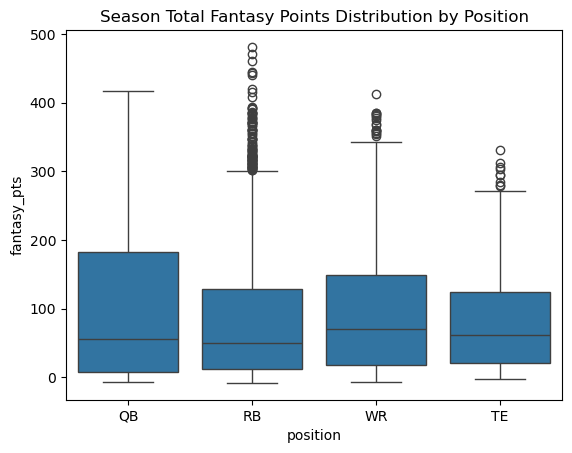

In [9]:
sns.boxplot(data=all_players, x='position', y='fantasy_pts')
plt.title('Season Total Fantasy Points Distribution by Position')
plt.show()

Which positions have the most year-to-year consistency in performance?

In [10]:
all_players['ff_pts_prev_year'] = all_players.groupby('id')['fantasy_pts'].shift(1)
all_players['ff_pts_diff'] = all_players['fantasy_pts'] - all_players['ff_pts_prev_year']
all_players.head()

season  reception  passing_yards  pass_touchdown  rush_touchdown  \
0    1999          0         1276.0             7.0             0.0   
1    2000          0         1047.0             2.0             0.0   
2    2001          0            0.0             0.0             0.0   
3    2002          0          134.0             1.0             0.0   
4    2003          0           16.0             0.0             0.0   

   interception  fumble_lost  rushing_yards  two_pt  receiving_yards  ...  \
0           9.0          6.0           33.0     0.0              0.0  ...   
1           8.0          0.0           68.0     0.0              0.0  ...   
2           0.0          0.0           -1.0     0.0              0.0  ...   
3           0.0          0.0           -1.0     0.0              0.0  ...   
4           0.0          0.0           -7.0     0.0              0.0  ...   

   birth_date height  weight college     gsis_id years_exp  \
0  1968-01-31   75.0   216.0     NaN  00-0012726       NaN   
1  1968-01-31   75.0   216.0     NaN  00-0012726       NaN   
2  1968-01-31   75.0   220.0     NaN  00-0012726       NaN   
3  1968-01-31   75.0   220.0     NaN  00-0012726      11.0   
4  1968-01-31   75.0   220.0     NaN  00-0012726      12.0   

                                        headshot_url rookie_year  \
0  https://static.www.nfl.com/image/private/f_aut...         NaN   
1  https://static.www.nfl.com/image/private/f_aut...         NaN   
2  https://static.www.nfl.com/image/private/f_aut...         NaN   
3  https://static.www.nfl.com/image/private/f_aut...      1991.0   
4  https://static.www.nfl.com/image/private/f_aut...      1991.0   

  ff_pts_prev_year ff_pts_diff  
0              NaN         NaN  
1            52.34      -11.66  
2            40.68      -40.78  
3            -0.10        9.36  
4             9.26       -9.32  

[5 rows x 31 columns]

In [11]:
all_players.groupby('position')['ff_pts_diff'].describe()

count      mean        std    min     25%   50%     75%     max
position                                                                  
QB        1612.0 -4.286179  82.299962 -387.0 -46.925 -2.07  32.735  406.72
RB        2725.0 -7.045930  73.558615 -394.8 -45.100 -2.10  24.200  332.80
TE         781.0 -0.681485  53.301115 -182.0 -29.900  0.00  26.200  205.40
WR        3433.0 -5.446391  67.852323 -307.6 -44.900 -3.00  31.900  325.80

Seems that Tight Ends have the greatest mean in ff pts difference year to year. Tight Ends also have the lowest standard deviation in points year to year.

What is the correlation between a player’s fantasy finish and:
ADP?
Team offensive stats?

In [12]:
#adp_data = adp_data_all_years(2024, split=True, save_to_csv=True, csv_filepath='../data/raw/adp_data.csv')
adp_data = pd.read_csv('../data/raw/adp_data.csv')
adp_data.head()

Rank Player Team (Bye)  POS  ESPN  Sleeper  NFL  RTSports  FFC  AVG  \
0     1      Le'Veon Bell  RB1   NaN      NaN  NaN       1.0  NaN  1.5   
1     2   Adrian Peterson  RB2   NaN      NaN  NaN       2.0  NaN  1.8   
2     3     Antonio Brown  WR1   NaN      NaN  NaN       4.0  NaN  3.8   
3     4    Jamaal Charles  RB3   NaN      NaN  NaN       5.0  NaN  4.0   
4     5        Eddie Lacy  RB4   NaN      NaN  NaN       3.0  NaN  4.0   

   season position  position_rank        full_name team  bye_week  
0    2015       RB            1.0     Le'Veon Bell  NaN       NaN  
1    2015       RB            2.0  Adrian Peterson  NaN       NaN  
2    2015       WR            1.0    Antonio Brown  NaN       NaN  
3    2015       RB            3.0   Jamaal Charles  NaN       NaN  
4    2015       RB            4.0       Eddie Lacy  NaN       NaN

In [13]:
final_merged = merge_adp_all_players(adp_data, all_players)

c:\Users\irela\Documents\NSS_Projects\ff-draft-optimizer\notebooks\../src\retreive_adp_data.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df_clean['original_key'] = matched_df_clean['original'].str.lower()
c:\Users\irela\Documents\NSS_Projects\ff-draft-optimizer\notebooks\../src\retreive_adp_data.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_df_clean['matched_key'] = matched_df_clean['matched'].str.lower()


In [14]:
#adp_season_df = merge_adp_all_players(adp_data, all_players)
#adp_season_df.to_csv('../data/processed/adp_season.csv', index=False)
adp_season_df = pd.read_csv('../data/processed/adp_season.csv')
adp_season_df.head()

id position  season  reception  passing_yards  pass_touchdown  \
0  00-0012726       QB    1999          0         1276.0             7.0   
1  00-0012726       QB    2000          0         1047.0             2.0   
2  00-0012726       QB    2001          0            0.0             0.0   
3  00-0012726       QB    2002          0          134.0             1.0   
4  00-0012726       QB    2003          0           16.0             0.0   

   rush_touchdown  interception  fumble_lost  rushing_yards  ...  Rank  ESPN  \
0             0.0           9.0          6.0           33.0  ...   NaN   NaN   
1             0.0           8.0          0.0           68.0  ...   NaN   NaN   
2             0.0           0.0          0.0           -1.0  ...   NaN   NaN   
3             0.0           0.0          0.0           -1.0  ...   NaN   NaN   
4             0.0           0.0          0.0           -7.0  ...   NaN   NaN   

   AVG  position_rank full_name_adp_data  bye_week position_season_end_rank  \
0  NaN            NaN                NaN       NaN                       44   
1  NaN            NaN                NaN       NaN                       41   
2  NaN            NaN                NaN       NaN                       70   
3  NaN            NaN                NaN       NaN                       54   
4  NaN            NaN                NaN       NaN                       75   

  season_end_rank position_season_end_rank_diff season_end_rank_diff  
0             198                           NaN                  NaN  
1             204                           NaN                  NaN  
2             341                           NaN                  NaN  
3             274                           NaN                  NaN  
4             340                           NaN                  NaN  

[5 rows x 40 columns]

In [15]:
adp_season_df = adp_season_df.rename(columns={'team_all_players':'team'})
adp_season_df['team_total_season_fantasy_pts'] = adp_season_df.groupby(['team', 'season'])['fantasy_pts'].transform('sum')

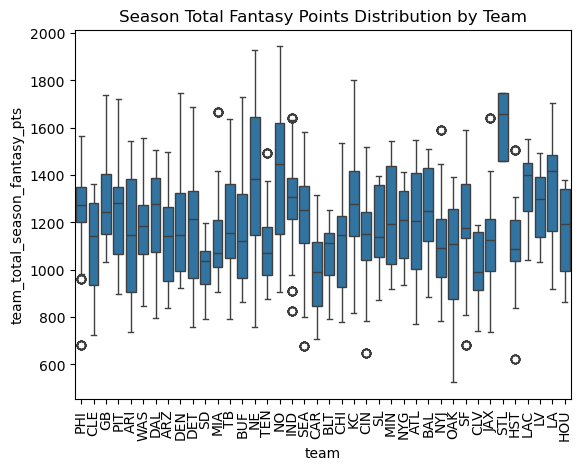

In [16]:
sns.boxplot(data=adp_season_df, x='team', y='team_total_season_fantasy_pts')
plt.title('Season Total Fantasy Points Distribution by Team')
plt.xticks(rotation=90)
plt.show()

In [17]:
corr = adp_season_df[['fantasy_pts', 'AVG', 'team_total_season_fantasy_pts', 'season_end_rank']]
corr.corr()

fantasy_pts       AVG  \
fantasy_pts                       1.000000 -0.607357   
AVG                              -0.607357  1.000000   
team_total_season_fantasy_pts     0.136010 -0.090594   
season_end_rank                  -0.934474  0.635665   

                               team_total_season_fantasy_pts  season_end_rank  
fantasy_pts                                         0.136010        -0.934474  
AVG                                                -0.090594         0.635665  
team_total_season_fantasy_pts                       1.000000        -0.046894  
season_end_rank                                    -0.046894         1.000000

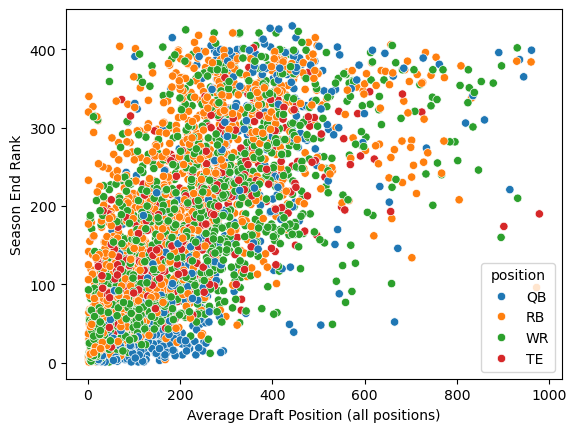

In [18]:
sns.scatterplot(data=adp_season_df, x='AVG', y='season_end_rank', hue='position')
plt.xlabel('Average Draft Position (all positions)')
plt.ylabel('Season End Rank')
plt.show()

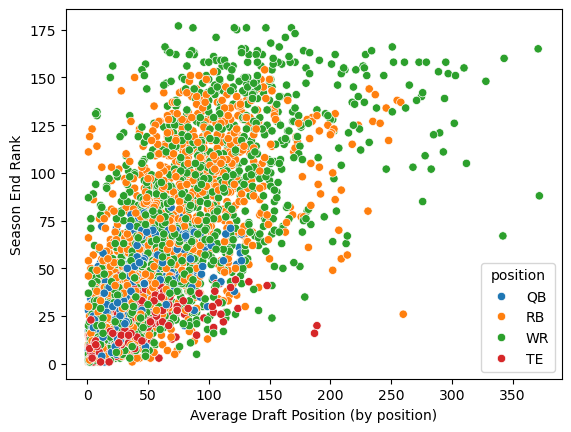

In [19]:
sns.scatterplot(data=adp_season_df, x='position_rank', y='position_season_end_rank', hue='position')
plt.xlabel('Average Draft Position (by position)')
plt.ylabel('Season End Rank')
plt.show()

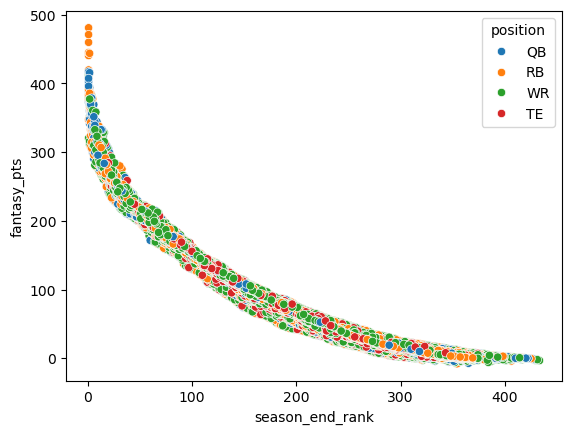

In [20]:
sns.scatterplot(data=adp_season_df, x='season_end_rank', y='fantasy_pts', hue='position')
plt.show()

What’s the average point drop-off between draft rounds?

In [21]:
# Say 12 teams (Could narrow this down)
num_teams = 12
total_slots_per_team = 14

"""
QB
RB
RB
WR
WR
TE
FLEX

BENCH x7

14 total slots per fantasy team
"""
adp_season_df['ESPN_reranked'] = adp_season_df.sort_values(['ESPN', 'fantasy_pts'], ascending=[True, False]).groupby('season').cumcount() + 1
adp_season_df['estimated_draft_round'] = ((adp_season_df['ESPN_reranked'].dropna() - 1) / (num_teams)).astype(int) + 1
adp_season_df['estimated_draft_round'] = np.where(adp_season_df['estimated_draft_round'] > total_slots_per_team, np.nan, adp_season_df['estimated_draft_round'].astype(int))
df_2024 = adp_season_df.loc[adp_season_df['season'] == 2024].copy()
df_2024.head()

id position  season  reception  passing_yards  pass_touchdown  \
3866  00-0023459       QB    2024          0         3623.0            24.0   
4850  00-0026158       QB    2024          0         1497.0            11.0   
5233  00-0026498       QB    2024          0         3762.0            20.0   
5366  00-0026300       QB    2024          0           17.0             0.0   
6085  00-0027973       QB    2024          0          989.0             7.0   

      rush_touchdown  interception  fumble_lost  rushing_yards  ...  \
3866             0.0          10.0          2.0          107.0  ...   
4850             0.0           7.0          4.0           26.0  ...   
5233             0.0           8.0          2.0           41.0  ...   
5366             0.0           0.0          0.0            1.0  ...   
6085             0.0           6.0          0.0           34.0  ...   

      position_rank  full_name_adp_data  bye_week  position_season_end_rank  \
3866           18.0       Aaron Rodgers       NaN                        16   
4850           39.0          Joe Flacco      10.0                        36   
5233           20.0    Matthew Stafford       6.0                        18   
5366           66.0        Josh Johnson      14.0                        65   
6085           60.0         Andy Dalton      11.0                        41   

     season_end_rank  position_season_end_rank_diff season_end_rank_diff  \
3866              40                           -2.0                -96.2   
4850             179                           -3.0               -138.5   
5233              54                           -2.0                -96.6   
5366             366                           -1.0                -80.5   
6085             214                          -19.0               -196.0   

     team_total_season_fantasy_pts ESPN_reranked estimated_draft_round  
3866                       1301.68            96                   8.0  
4850                        981.60           189                   NaN  
5233                       1164.48           137                  12.0  
5366                       1508.88           209                   NaN  
6085                        986.44           216                   NaN  

[5 rows x 43 columns]

In [22]:
adp_season_df.groupby('estimated_draft_round')['fantasy_pts'].describe()

count        mean        std    min      25%     50%  \
estimated_draft_round                                                         
1.0                    312.0  302.452115  68.571723  13.00  282.075  309.44   
2.0                    312.0  257.118910  56.616746  14.10  252.635  269.88   
3.0                    312.0  236.091474  43.757229  50.00  227.675  243.54   
4.0                    312.0  215.787436  43.011110   9.60  209.905  222.15   
5.0                    312.0  199.528590  42.212693   2.70  193.405  203.95   
6.0                    312.0  178.823013  46.969433  16.68  175.010  187.15   
7.0                    312.0  169.371667  47.275585   2.00  161.550  173.30   
8.0                    312.0  160.621667  44.757962  -0.20  149.260  158.85   
9.0                    312.0  146.523205  47.958460   9.80  133.500  146.12   
10.0                   312.0  132.322628  39.506821   3.20  121.675  134.14   
11.0                   312.0  123.556410  41.307549   2.60  109.550  122.50   
12.0                   312.0  115.726410  42.949261   7.40   99.575  112.25   
13.0                   312.0  111.893654  47.853647   0.00   92.550  102.46   
14.0                   312.0  100.228654  40.677521   0.00   83.125   93.80   

                           75%     max  
estimated_draft_round                   
1.0                    340.340  481.10  
2.0                    283.725  385.50  
3.0                    255.225  407.40  
4.0                    232.300  412.90  
5.0                    212.650  378.74  
6.0                    194.400  353.34  
7.0                    180.925  383.26  
8.0                    166.350  396.06  
9.0                    152.750  417.08  
10.0                   142.450  281.74  
11.0                   130.000  315.22  
12.0                   118.950  344.36  
13.0                   110.300  344.16  
14.0                   101.100  274.86

Text(0.5, 1.0, 'Fantasy Points Distribution by Estimated Draft Round')

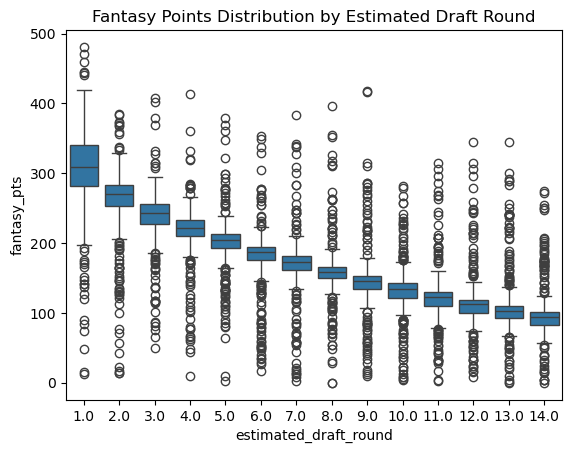

In [23]:
sns.boxplot(data=adp_season_df, x='estimated_draft_round', y='fantasy_pts')
plt.title('Fantasy Points Distribution by Estimated Draft Round')

In [24]:
avg_drop_off = adp_season_df.groupby('estimated_draft_round')['fantasy_pts'].mean().reset_index()
avg_drop_off['previous_round_avg_fantasy_pts'] = avg_drop_off['fantasy_pts'].shift(1)
avg_drop_off['avg_drop_off'] = avg_drop_off['fantasy_pts'] - avg_drop_off['previous_round_avg_fantasy_pts']
avg_drop_off[['estimated_draft_round', 'avg_drop_off']]

estimated_draft_round  avg_drop_off
0                     1.0           NaN
1                     2.0    -45.333205
2                     3.0    -21.027436
3                     4.0    -20.304038
4                     5.0    -16.258846
5                     6.0    -20.705577
6                     7.0     -9.451346
7                     8.0     -8.750000
8                     9.0    -14.098462
9                    10.0    -14.200577
10                   11.0     -8.766218
11                   12.0     -7.830000
12                   13.0     -3.832756
13                   14.0    -11.665000

Which positions/players are historically most over- or under-projected?

In [25]:
# Let's look at ADP vs season end rankings
adp_season_df['ADP_diff'] = adp_season_df['AVG'] - adp_season_df['season_end_rank']
adp_season_df.groupby('position')['ADP_diff'].describe().sort_values('mean', ascending=False)

count       mean         std    min     25%    50%      75%    max
position                                                                     
QB         568.0  91.441197  120.433676 -289.2  25.625  82.45  145.200  694.0
TE         326.0  55.113497  123.695024 -263.0 -20.950  32.20  109.125  789.0
WR        1299.0  53.995766  132.410839 -329.8 -23.000  29.30  114.750  736.0
RB        1183.0  16.178360  131.672070 -338.0 -61.850   0.00   69.250  877.0

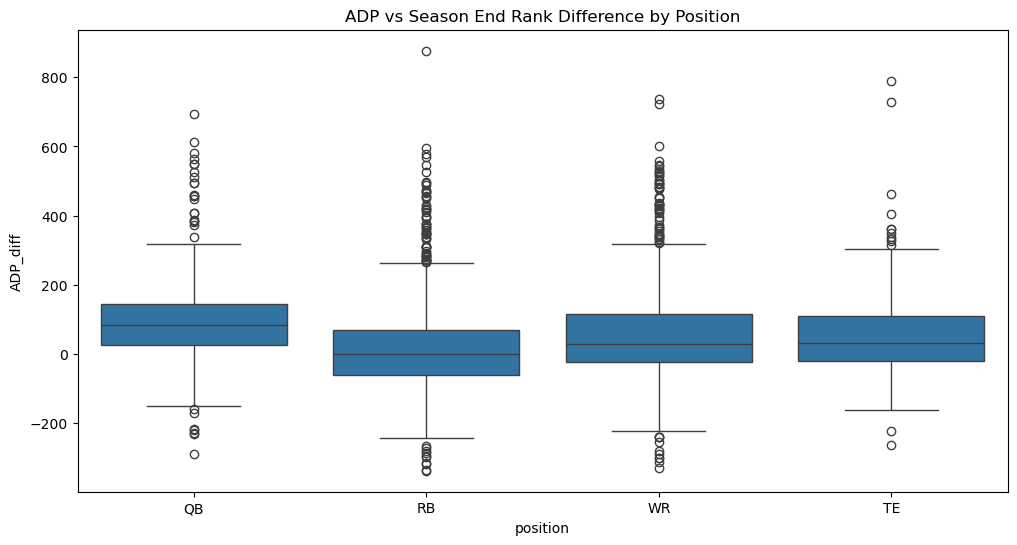

In [26]:
# Let's visualize the difference between ADP and season end rank
plt.figure(figsize=(12, 6))
sns.boxplot(data=adp_season_df, x='position', y='ADP_diff')
plt.title('ADP vs Season End Rank Difference by Position')
plt.show()

It seems that Quarterbacks tend to be most over-valued, while Running Backs are least over-valued.

In [27]:
# Let's come back with projeted vs actual fantasy points

What % of drafted players miss significant time?

In [28]:
injuries = pd.read_csv('../data/raw/injuries.csv', index_col=0)
# Only look at injuries that occurred before week 18
seasonal_injuries = injuries.loc[injuries['week']<18].copy()
seasonal_injuries = seasonal_injuries.groupby(['gsis_id', 'season']).agg({'week': 'count'}).reset_index()
seasonal_injuries = seasonal_injuries.rename(columns={'week': 'injury_count_num_weeks'})
seasonal_injuries = seasonal_injuries[['gsis_id', 'season', 'injury_count_num_weeks']]
seasonal_injuries.head()

gsis_id  season  injury_count_num_weeks
0  00-0000045    2009                       2
1  00-0000045    2010                       4
2  00-0000108    2010                       1
3  00-0000108    2012                       5
4  00-0000551    2009                       1

In [29]:
adp_season_df = pd.merge(adp_season_df, seasonal_injuries, how='left', left_on=['gsis_id', 'season'], right_on=['gsis_id', 'season'])
adp_season_df.head()

id position  season  reception  passing_yards  pass_touchdown  \
0  00-0012726       QB    1999          0         1276.0             7.0   
1  00-0012726       QB    2000          0         1047.0             2.0   
2  00-0012726       QB    2001          0            0.0             0.0   
3  00-0012726       QB    2002          0          134.0             1.0   
4  00-0012726       QB    2003          0           16.0             0.0   

   rush_touchdown  interception  fumble_lost  rushing_yards  ...  bye_week  \
0             0.0           9.0          6.0           33.0  ...       NaN   
1             0.0           8.0          0.0           68.0  ...       NaN   
2             0.0           0.0          0.0           -1.0  ...       NaN   
3             0.0           0.0          0.0           -1.0  ...       NaN   
4             0.0           0.0          0.0           -7.0  ...       NaN   

   position_season_end_rank  season_end_rank  position_season_end_rank_diff  \
0                        44              198                            NaN   
1                        41              204                            NaN   
2                        70              341                            NaN   
3                        54              274                            NaN   
4                        75              340                            NaN   

  season_end_rank_diff  team_total_season_fantasy_pts ESPN_reranked  \
0                  NaN                         681.60           209   
1                  NaN                         722.66           212   
2                  NaN                        1335.14           381   
3                  NaN                        1245.02           291   
4                  NaN                        1283.68           375   

  estimated_draft_round ADP_diff injury_count_num_weeks  
0                   NaN      NaN                    NaN  
1                   NaN      NaN                    NaN  
2                   NaN      NaN                    NaN  
3                   NaN      NaN                    NaN  
4                   NaN      NaN                    NaN  

[5 rows x 45 columns]

In [30]:
# Let's define 'significant injury' as 4 or more weeks
significant_injury_time = 4
adp_season_df['significant_injury'] = np.where(adp_season_df['injury_count_num_weeks'] >= significant_injury_time, 1, 0)
drafted_players = adp_season_df.loc[adp_season_df['ESPN_reranked'].notna()]
drafted_players.groupby(['estimated_draft_round', 'significant_injury'])['fantasy_pts'].mean().reset_index()

estimated_draft_round  significant_injury  fantasy_pts
0                     1.0                   0   318.532941
1                     1.0                   1   272.077222
2                     2.0                   0   263.602593
3                     2.0                   1   242.530625
4                     3.0                   0   239.960288
5                     3.0                   1   228.353846
6                     4.0                   0   216.570857
7                     4.0                   1   214.174510
8                     5.0                   0   203.272020
9                     5.0                   1   192.556881
10                    6.0                   0   182.300748
11                    6.0                   1   171.228776
12                    7.0                   0   171.786849
13                    7.0                   1   163.684301
14                    8.0                   0   158.610142
15                    8.0                   1   164.823960
16                    9.0                   0   149.948384
17                    9.0                   1   137.073012
18                   10.0                   0   131.260531
19                   10.0                   1   135.113721
20                   11.0                   0   121.287532
21                   11.0                   1   130.026914
22                   12.0                   0   115.339414
23                   12.0                   1   116.993425
24                   13.0                   0   108.363246
25                   13.0                   1   121.476190
26                   14.0                   0    94.313067
27                   14.0                   1   115.527586

It looks like players in later rounds actually end up with more fantasy points on average if they have a significant injury, most likely because an injury is an indication of some significant level of playing time. However, players in rounds 1-8 do lose fantasy value due to injuries.

In [31]:
# What percentage of players drafted in each round had a significant injury?
injury_percentage = drafted_players.groupby(['significant_injury'])['fantasy_pts'].count().reset_index()
injury_percentage = injury_percentage.rename(columns={'fantasy_pts': 'count'})
#injury_percentage = injury_percentage.pivot(index='estimated_draft_round', columns='significant_injury', values='count').reset_index()
injury_percentage = injury_percentage[injury_percentage['significant_injury'] == 1]['count']/injury_percentage['count'].sum()
print(f"Percentage of players drafted with significant injury: {injury_percentage.iloc[0]:.2%}")

Percentage of players drafted with significant injury: 20.82%


How much does injury risk affect fantasy point variability?

In [32]:
# How to quantify injury risk?

# Let's look at the distribution of injuries by position
injury_distribution = (
    adp_season_df.groupby('position')
    .agg(
        total_injury_weeks=('injury_count_num_weeks', 'sum'),
        num_players=('gsis_id', 'nunique')
    )
    .reset_index()
)

injury_distribution['injury_weeks_per_player'] = (
    injury_distribution['total_injury_weeks'] / injury_distribution['num_players']
)

injury_distribution


position  total_injury_weeks  num_players  injury_weeks_per_player
0       QB              2603.0          400                 6.507500
1       RB              6403.0          980                 6.533673
2       TE              2221.0          147                15.108844
3       WR              9208.0          898                10.253898

In [33]:
player_injury_stats = adp_season_df.dropna(subset=['estimated_draft_round']).groupby(['position']).agg(
    injury_weeks=('injury_count_num_weeks', 'sum'),
    avg_points=('fantasy_pts', 'mean'),
    std_points=('fantasy_pts', 'std')
).reset_index()

player_injury_stats['point_variability'] = player_injury_stats['std_points'] / player_injury_stats['avg_points']
player_injury_stats.sort_values('point_variability', ascending=False)

position  injury_weeks  avg_points  std_points  point_variability
1       RB        3375.0  168.753426   79.511751           0.471171
3       WR        5132.0  170.241821   68.860759           0.404488
0       QB        1733.0  206.408403   78.637463           0.380980
2       TE        1080.0  150.658754   55.515066           0.368482

Are injury-prone players still top scorers when healthy?

In [34]:
# We will define injury prone as a player who has sustained a significant injury at least twice in the last 3 seasons
injury_per_season = (
    adp_season_df[adp_season_df['significant_injury']==1]
    .groupby(['gsis_id', 'season'])
    .size()
    .reset_index(name='significant_injury_count')
)

all_seasons = adp_season_df['season'].unique()
players = adp_season_df['gsis_id'].unique()

player_season_index = pd.MultiIndex.from_product([players, all_seasons], names=['gsis_id', 'season'])
injury_rollup = pd.DataFrame(index=player_season_index).reset_index()

injury_rollup = injury_rollup.merge(injury_per_season, on=['gsis_id', 'season'], how='left')
injury_rollup['significant_injury_count'] = injury_rollup['significant_injury_count'].fillna(0)

injury_rollup = injury_rollup.sort_values(['gsis_id', 'season'])

injury_rollup['rolling_injury_count'] = (
    injury_rollup
    .groupby('gsis_id')['significant_injury_count']
    .rolling(window=3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

injury_rollup['injury_prone'] = injury_rollup['rolling_injury_count'] >= 2
injury_rollup['injury_prone'] = np.where(injury_rollup['season'] >=2009, injury_rollup['injury_prone'], np.nan)

adp_season_df = adp_season_df.merge(
    injury_rollup[['gsis_id', 'season', 'injury_prone']],
    on=['gsis_id', 'season'],
    how='left'
)

injury_rollup.head()

gsis_id  season  significant_injury_count  rolling_injury_count  \
1612  00-0000003    1999                       0.0                   0.0   
1613  00-0000003    2000                       0.0                   0.0   
1614  00-0000003    2001                       0.0                   0.0   
1615  00-0000003    2002                       0.0                   0.0   
1616  00-0000003    2003                       0.0                   0.0   

      injury_prone  
1612           NaN  
1613           NaN  
1614           NaN  
1615           NaN  
1616           NaN

In [35]:
adp_season_df.dropna(subset=['estimated_draft_round']).groupby(['position', 'injury_prone'])['fantasy_pts'].describe()

count        mean        std    min      25%     50%  \
position injury_prone                                                         
QB       0.0           371.0  223.446954  79.225069   0.72  165.200  225.62   
         1.0           116.0  232.932931  88.256325   0.00  168.730  247.01   
RB       0.0           573.0  156.846143  77.910772  -0.20  107.200  147.60   
         1.0           270.0  175.090296  78.120414   2.00  120.450  173.10   
TE       0.0           152.0  158.697105  57.140762  15.10  119.225  147.35   
         1.0            94.0  144.891915  57.890377   9.20  109.475  138.60   
WR       0.0           679.0  166.975788  68.204295   0.00  117.500  159.40   
         1.0           433.0  175.308453  75.018380   9.10  115.800  171.70   

                           75%     max  
position injury_prone                   
QB       0.0           278.800  417.08  
         1.0           296.660  397.14  
RB       0.0           202.200  407.80  
         1.0           221.625  471.20  
TE       0.0           191.025  330.90  
         1.0           183.100  303.50  
WR       0.0           211.500  412.90  
         1.0           224.400  377.40

In [36]:
injury_prone_players = adp_season_df.loc[adp_season_df['injury_prone'] == True, 'gsis_id'].unique()
injury_prone = adp_season_df[adp_season_df['gsis_id'].isin(injury_prone_players)].copy()
injury_prone.dropna(subset=['estimated_draft_round']).groupby(['significant_injury'])['fantasy_pts'].describe()

count        mean        std  min    25%    50%     75%  \
significant_injury                                                             
0                   1055.0  192.024796  79.028761 -0.2  133.2  189.8  244.18   
1                   1131.0  178.863554  73.772922  0.0  125.3  172.8  225.38   

                      max  
significant_injury         
0                   481.1  
1                   471.2

How does team offensive rank affect player fantasy outcomes?

In [37]:
adp_season_df['team_rank'] = adp_season_df.groupby(['season'])['team_total_season_fantasy_pts'].rank(ascending=False, method='dense')
adp_season_df.head()

id position  season  reception  passing_yards  pass_touchdown  \
0  00-0012726       QB    1999          0         1276.0             7.0   
1  00-0012726       QB    2000          0         1047.0             2.0   
2  00-0012726       QB    2001          0            0.0             0.0   
3  00-0012726       QB    2002          0          134.0             1.0   
4  00-0012726       QB    2003          0           16.0             0.0   

   rush_touchdown  interception  fumble_lost  rushing_yards  ...  \
0             0.0           9.0          6.0           33.0  ...   
1             0.0           8.0          0.0           68.0  ...   
2             0.0           0.0          0.0           -1.0  ...   
3             0.0           0.0          0.0           -1.0  ...   
4             0.0           0.0          0.0           -7.0  ...   

   position_season_end_rank_diff  season_end_rank_diff  \
0                            NaN                   NaN   
1                            NaN                   NaN   
2                            NaN                   NaN   
3                            NaN                   NaN   
4                            NaN                   NaN   

   team_total_season_fantasy_pts  ESPN_reranked estimated_draft_round  \
0                         681.60            209                   NaN   
1                         722.66            212                   NaN   
2                        1335.14            381                   NaN   
3                        1245.02            291                   NaN   
4                        1283.68            375                   NaN   

   ADP_diff injury_count_num_weeks significant_injury injury_prone team_rank  
0       NaN                    NaN                  0          NaN      30.0  
1       NaN                    NaN                  0          NaN      30.0  
2       NaN                    NaN                  0          NaN       2.0  
3       NaN                    NaN                  0          NaN       9.0  
4       NaN                    NaN                  0          NaN       7.0  

[5 rows x 48 columns]

In [38]:
adp_season_df[['fantasy_pts', 'team_rank']].corr()

fantasy_pts  team_rank
fantasy_pts      1.00000   -0.14468
team_rank       -0.14468    1.00000

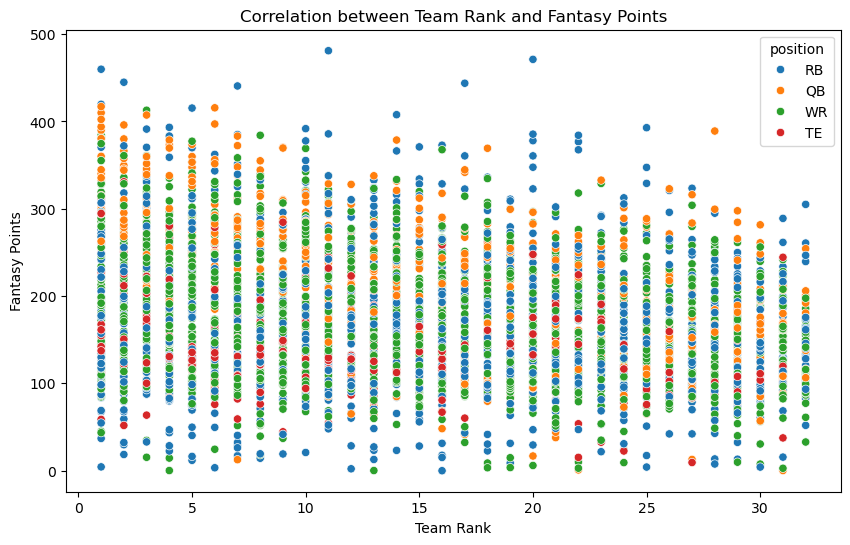

In [39]:
# Plot the correlation between fantasy points and team rank
plt.figure(figsize=(10, 6))
sns.scatterplot(data=adp_season_df.dropna(subset=['estimated_draft_round']), y='fantasy_pts', x='team_rank', hue='position')
plt.title('Correlation between Team Rank and Fantasy Points')
plt.ylabel('Fantasy Points')
plt.xlabel('Team Rank')
plt.show()

Do players perform better/worse when switching teams?

In [40]:
# Identify players that switch teams
adp_season_df['team_change'] = adp_season_df.groupby(['gsis_id'])['team'].shift(1) != adp_season_df['team']
adp_season_df['team_change'] = np.where(adp_season_df['team_change'] == True, 1, 0)
adp_season_df.groupby(['position', 'team_change'])['ff_pts_diff'].describe()

count       mean        std     min     25%   50%  \
position team_change                                                       
QB       0            1099.0  -1.285660  85.020634 -387.00 -46.460 -0.96   
         1             521.0 -10.244645  75.383434 -302.96 -47.060 -2.60   
RB       0            1937.0  -4.525101  76.518279 -394.80 -42.500 -1.60   
         1             808.0 -13.407970  64.721787 -274.00 -51.175 -3.00   
TE       0             611.0  -1.034141  54.344833 -182.00 -28.300  0.00   
         1             174.0   0.571954  48.949567 -163.10 -31.100  0.00   
WR       0            2393.0  -2.190639  69.939120 -290.70 -43.100 -1.60   
         1            1048.0 -12.664179  62.081199 -307.60 -48.900 -5.60   

                         75%     max  
position team_change                  
QB       0            38.060  406.72  
         1            22.380  294.40  
RB       0            31.800  332.80  
         1             8.675  306.40  
TE       0            26.400  205.40  
         1            23.775  152.80  
WR       0            39.400  325.80  
         1            13.280  268.90

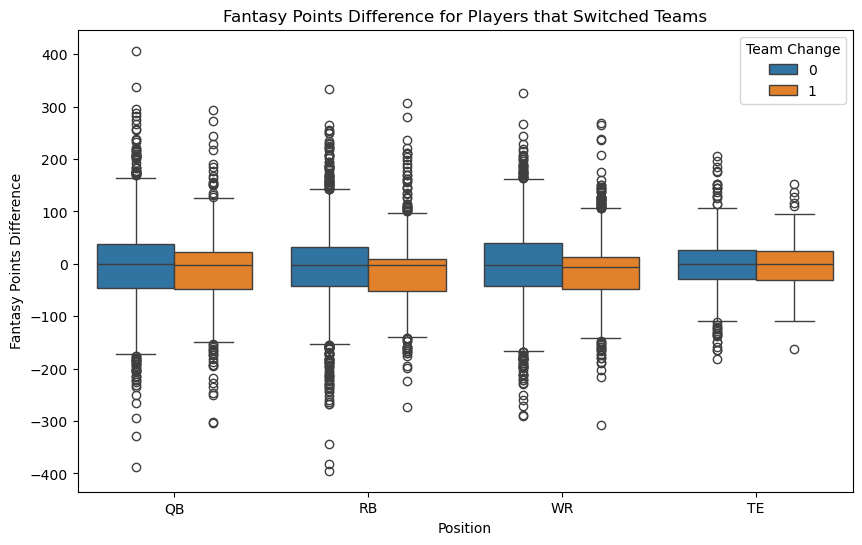

In [41]:
# Visualize the difference in fantasy points for players that switched teams
plt.figure(figsize=(10, 6))
sns.boxplot(data=adp_season_df, x='position', y='ff_pts_diff', hue='team_change')
plt.title('Fantasy Points Difference for Players that Switched Teams')
plt.xlabel('Position')
plt.ylabel('Fantasy Points Difference')
plt.legend(title='Team Change', loc='upper right')
plt.show()

It seems that most players do worse when changing teams, with the exception of Tight Ends

In [42]:
# What happens when a player switches to a better ranked team?
switched_teams = adp_season_df.loc[adp_season_df['team_change'] == 1].copy()
switched_teams['team_rank_prev'] = switched_teams.groupby(['gsis_id'])['team_rank'].shift(1)
switched_teams['new_team_rank_better'] = np.where(switched_teams['team_rank_prev'] > switched_teams['team_rank'], 1, 0)
switched_teams.groupby(['position', 'new_team_rank_better'])['ff_pts_diff'].describe()

count       mean        std     min    25%  \
position new_team_rank_better                                               
QB       0                     262.0  -6.372595  76.837253 -301.34 -45.55   
         1                     259.0 -14.161544  73.825378 -302.96 -48.76   
RB       0                     416.0 -14.358702  62.370640 -274.00 -49.55   
         1                     392.0 -12.399031  67.192225 -198.08 -52.65   
TE       0                      83.0   2.868916  52.031105 -109.40 -31.00   
         1                      91.0  -1.523077  46.150447 -163.10 -31.25   
WR       0                     553.0 -14.134141  59.008624 -190.10 -47.80   
         1                     495.0 -11.021980  65.364336 -307.60 -50.35   

                                50%     75%     max  
position new_team_rank_better                        
QB       0                     0.00  32.265  294.40  
         1                    -6.72   9.060  271.90  
RB       0                    -2.60   7.540  279.62  
         1                    -4.50   9.125  306.40  
TE       0                     0.00  25.950  152.80  
         1                     0.10  19.150   94.60  
WR       0                    -4.70  12.600  238.80  
         1                    -6.60  15.050  268.90

When players do switch teams, WRs and RBs do better on a better ranked team. QBs and TEs do worse on a better team, on average.

How often do sleepers (late-round picks) end up as top-20 players?

In [43]:
# Let's consider a late-round pick as a player drafted in the 10th round or later
late_round_players = adp_season_df.loc[(adp_season_df['estimated_draft_round'] >= 10) | (adp_season_df['estimated_draft_round'].isna())].copy()
sleepers = late_round_players[late_round_players['season_end_rank'] <= 20]
sleepers.head()

id position  season  reception  passing_yards  pass_touchdown  \
3795  00-0023436       QB    2017          0         4042.0            26.0   
6501  00-0029701       QB    2020          1         3819.0            33.0   
6688  00-0029604       QB    2020          0         4265.0            35.0   
6954  00-0030565       QB    2022          0         4069.0            29.0   
7809  00-0031503       QB    2019          0         5109.0            33.0   

      rush_touchdown  interception  fumble_lost  rushing_yards  ...  \
3795             1.0           5.0          1.0          323.0  ...   
6501             7.0           7.0          1.0          266.0  ...   
6688             1.0          13.0          5.0          156.0  ...   
6954             1.0           9.0          4.0          315.0  ...   
7809             1.0          30.0          5.0          250.0  ...   

      season_end_rank_diff  team_total_season_fantasy_pts  ESPN_reranked  \
3795                -224.0                        1402.74            152   
6501                -148.5                        1492.34            137   
6688                -148.7                        1458.90            143   
6954                   NaN                        1383.56            175   
7809                -116.5                        1361.78            128   

      estimated_draft_round ADP_diff  injury_count_num_weeks  \
3795                   13.0    224.0                     1.0   
6501                   12.0    148.5                     NaN   
6688                   12.0    148.7                     NaN   
6954                    NaN      NaN                     1.0   
7809                   11.0    116.5                     6.0   

     significant_injury injury_prone team_rank team_change  
3795                  0          0.0       5.0           0  
6501                  0          0.0       8.0           0  
6688                  0          0.0      11.0           0  
6954                  0          0.0      11.0           0  
7809                  1          1.0      12.0           0  

[5 rows x 49 columns]

In [44]:
print(f'Percentage of late round players (10th round or later) that end ip as top-20 player: {len(sleepers)/len(late_round_players):.4%}')

Percentage of late round players (10th round or later) that end ip as top-20 player: 0.2692%


In [45]:
sleepers.groupby('position')['fantasy_pts'].describe()

count        mean        std     min      25%     50%      75%  \
position                                                                   
QB         19.0  299.335789  21.836224  267.88  287.000  295.60  305.780   
RB          2.0  291.050000  33.021887  267.70  279.375  291.05  302.725   
WR          1.0  284.400000        NaN  284.40  284.400  284.40  284.400   

             max  
position          
QB        344.36  
RB        314.40  
WR        284.40

Almost all sleepers are quarterbacks!

In [46]:
late_round_players.groupby('estimated_draft_round')['fantasy_pts'].describe()

count        mean        std  min      25%     50%  \
estimated_draft_round                                                       
10.0                   312.0  132.322628  39.506821  3.2  121.675  134.14   
11.0                   312.0  123.556410  41.307549  2.6  109.550  122.50   
12.0                   312.0  115.726410  42.949261  7.4   99.575  112.25   
13.0                   312.0  111.893654  47.853647  0.0   92.550  102.46   
14.0                   312.0  100.228654  40.677521  0.0   83.125   93.80   

                          75%     max  
estimated_draft_round                  
10.0                   142.45  281.74  
11.0                   130.00  315.22  
12.0                   118.95  344.36  
13.0                   110.30  344.16  
14.0                   101.10  274.86

How close were preseason projections to actual outcomes? What level of variance exists in player outcomes vs. projections?

In [47]:
cols_to_shift = ['reception', 'passing_yards',
       'pass_touchdown', 'rush_touchdown', 'interception', 'fumble_lost',
       'rushing_yards', 'two_pt', 'receiving_yards', 'receive_touchdown',
       'ff_pts_diff', 'Rank', 'ESPN', 'AVG', 'position_rank', 'position_season_end_rank', 'season_end_rank',
       'position_season_end_rank_diff', 'season_end_rank_diff', 'ESPN_reranked', 'ADP_diff', 'injury_count_num_weeks',
       'significant_injury']

cols_to_keep_in_season = ['season', 'gsis_id', 'full_name_all_players', 'fantasy_pts', 'position', 'ff_pts_prev_year', 'years_exp', 'Rank', 'ESPN', 'AVG', 'position_rank', 'injury_prone', 'team_change']


prev_season = adp_season_df.groupby('gsis_id')[cols_to_shift].shift(1)
prev_season.columns = [f'{col}_prev_season' for col in cols_to_shift]

projection_models_data = adp_season_df[cols_to_keep_in_season]
projection_models_data = pd.concat([projection_models_data, prev_season], axis=1)

# will need to handle team total fantasy points/team rank to handle team changes
#projection_models_data.to_csv('../data/processed/projection_models_data.csv', index=False)
projection_models_data.head()

season     gsis_id full_name_all_players  fantasy_pts position  \
0    1999  00-0012726         Doug Pederson        52.34       QB   
1    2000  00-0012726         Doug Pederson        40.68       QB   
2    2001  00-0012726         Doug Pederson        -0.10       QB   
3    2002  00-0012726         Doug Pederson         9.26       QB   
4    2003  00-0012726         Doug Pederson        -0.06       QB   

   ff_pts_prev_year  years_exp  Rank  ESPN  AVG  ...  AVG_prev_season  \
0               NaN        NaN   NaN   NaN  NaN  ...              NaN   
1             52.34        NaN   NaN   NaN  NaN  ...              NaN   
2             40.68        NaN   NaN   NaN  NaN  ...              NaN   
3             -0.10       11.0   NaN   NaN  NaN  ...              NaN   
4              9.26       12.0   NaN   NaN  NaN  ...              NaN   

   position_rank_prev_season  position_season_end_rank_prev_season  \
0                        NaN                                   NaN   
1                        NaN                                  44.0   
2                        NaN                                  41.0   
3                        NaN                                  70.0   
4                        NaN                                  54.0   

   season_end_rank_prev_season  position_season_end_rank_diff_prev_season  \
0                          NaN                                        NaN   
1                        198.0                                        NaN   
2                        204.0                                        NaN   
3                        341.0                                        NaN   
4                        274.0                                        NaN   

   season_end_rank_diff_prev_season  ESPN_reranked_prev_season  \
0                               NaN                        NaN   
1                               NaN                      209.0   
2                               NaN                      212.0   
3                               NaN                      381.0   
4                               NaN                      291.0   

   ADP_diff_prev_season  injury_count_num_weeks_prev_season  \
0                   NaN                                 NaN   
1                   NaN                                 NaN   
2                   NaN                                 NaN   
3                   NaN                                 NaN   
4                   NaN                                 NaN   

   significant_injury_prev_season  
0                             NaN  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0  

[5 rows x 36 columns]

In [48]:
# Our training data will be 2014 - 2022, and our test data will be 2023-2024. 
# We will exclude id's, names, team names, etc., and will try and include as much info about the previous season as possible.

pm_data = pd.read_csv('../data/processed/projection_models_data.csv')
#pm_data = pm_data[pm_data['season']>=2014]
#pm_data = pm_data[pm_data['season']>=2012]

projection_models_train = pm_data[pm_data['season']<2023]
projection_models_test = pm_data[pm_data['season']>=2023]

projection_models_test = pd.get_dummies(projection_models_test, columns=['position'])
projection_models_train = pd.get_dummies(projection_models_train, columns=['position'])
    
projection_models_test.to_csv('../data/processed/projection_models_test.csv', index=False)
projection_models_train.to_csv('../data/processed/projection_models_train.csv', index=False)

projection_models_test = pd.read_csv('../data/processed/projection_models_test.csv')
projection_models_train = pd.read_csv('../data/processed/projection_models_train.csv')

projection_models_train.head()

season     gsis_id full_name_all_players  fantasy_pts  ff_pts_prev_year  \
0    1999  00-0012726         Doug Pederson        52.34               NaN   
1    2000  00-0012726         Doug Pederson        40.68             52.34   
2    2001  00-0012726         Doug Pederson        -0.10             40.68   
3    2002  00-0012726         Doug Pederson         9.26             -0.10   
4    2003  00-0012726         Doug Pederson        -0.06              9.26   

   years_exp  Rank  ESPN  AVG  position_rank  ...  \
0        NaN   NaN   NaN  NaN            NaN  ...   
1        NaN   NaN   NaN  NaN            NaN  ...   
2        NaN   NaN   NaN  NaN            NaN  ...   
3       11.0   NaN   NaN  NaN            NaN  ...   
4       12.0   NaN   NaN  NaN            NaN  ...   

   position_season_end_rank_diff_prev_season  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   season_end_rank_diff_prev_season  ESPN_reranked_prev_season  \
0                               NaN                        NaN   
1                               NaN                      209.0   
2                               NaN                      212.0   
3                               NaN                      381.0   
4                               NaN                      291.0   

   ADP_diff_prev_season  injury_count_num_weeks_prev_season  \
0                   NaN                                 NaN   
1                   NaN                                 NaN   
2                   NaN                                 NaN   
3                   NaN                                 NaN   
4                   NaN                                 NaN   

   significant_injury_prev_season  position_QB  position_RB  position_TE  \
0                             NaN         True        False        False   
1                             0.0         True        False        False   
2                             0.0         True        False        False   
3                             0.0         True        False        False   
4                             0.0         True        False        False   

   position_WR  
0        False  
1        False  
2        False  
3        False  
4        False  

[5 rows x 39 columns]

In [49]:
cols_to_drop = ['season', 'gsis_id', 'full_name_all_players', 'fantasy_pts']

X_train = projection_models_train.drop(columns=cols_to_drop)
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=cols_to_drop)
y_test = projection_models_test[['fantasy_pts']]

X_train_cols = projection_models_train.drop(columns=cols_to_drop).columns.tolist()
X_train_index = X_train.index
X_test_index = X_test.index

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=X_train_cols, index=X_train_index)
X_test_df = pd.DataFrame(X_test, columns=X_train_cols, index=X_test_index)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_poly)
X_test_pca = pca.transform(X_test_poly)

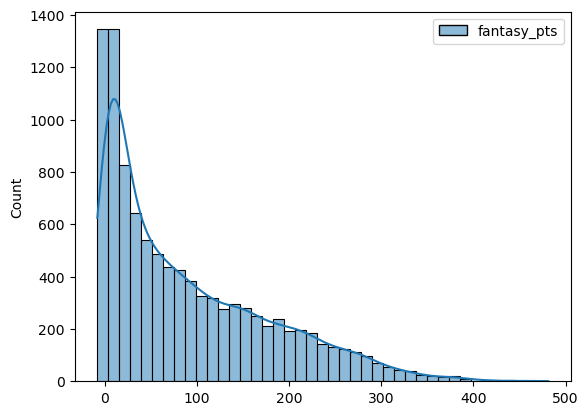

In [50]:
sns.histplot(y_train, kde=True)
plt.show()

In [51]:
y_train_binary = y_train <= 83.125
y_test_binary = y_test <= 83.125

pipe = Pipeline([
    ('classifier', LogisticRegression())
])

pipe.fit(X_train_pca, y_train_binary)

y_pred = pipe.predict(X_test_pca)

accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

print(confusion_matrix(y_test_binary, y_pred))

X_test_draftable = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
X_train_draftable = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

X_test_draftable['is_draftable'] = y_pred.astype(int)
X_train_draftable['is_draftable'] = y_train_binary.astype(int)

Accuracy: 0.80
Precision: 0.81
Recall: 0.85
[[269 100]
 [ 77 427]]


c:\Users\irela\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
df = pd.DataFrame(X_train_draftable)
df["target"] = y_train.values

df_clean = df.dropna()

X_train_lr = df_clean.drop("target", axis=1)
y_train_lr = df_clean["target"]

lr = LinearRegression()

lr.fit(X_train_lr, y_train_lr)

coef_mean = lr.coef_
intercept_mean = lr.intercept_

residuals = y_train_lr - lr.predict(X_train_lr)
sigma_est = residuals.std()

print(f"Mean of coefficients: {coef_mean}")
print(f"Mean of intercept: {intercept_mean}")
print(f"Standard deviation of residuals: {sigma_est}")

X_pm_train = df_clean.drop("target", axis=1).values
y_pm_train = df_clean["target"].values

basic_model = pm.Model()

feature_names = df_clean.drop("target", axis=1).columns.tolist()

"""

with pm.Model(coords={"features": feature_names}) as model:
    X_data = pm.Data("X_data", X_pm_train, dims=("obs", "features"))
    y_data = pm.Data("y_data", y_pm_train, dims="obs")

    intercept = pm.Normal("intercept", mu=intercept_mean, sigma=5)

    betas = pm.Normal("betas", mu=coef_mean.flatten() if coef_mean.ndim > 1 else coef_mean, sigma=1.0, dims="features")
    sigma = pm.HalfNormal("sigma", sigma=sigma_est)

    mu = intercept + pm.math.dot(X_data, betas)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data, dims="obs")

    trace = pm.sample(draws=2000, tune=2000, chains=4, cores=4, target_accept=0.95, random_seed=11)

"""

Mean of coefficients: [ 9.91295941e-01  1.72261665e+00 -3.05183821e-01  9.54948783e-01
 -9.77401009e-01  4.09459254e-01 -1.63103641e-02  7.18608855e-01
 -2.51804735e-01 -6.93087510e-01 -4.27679959e-01  1.70822275e+00
 -9.06972616e-02 -5.29492280e-01  2.56939730e-01 -2.33693069e-01
  2.91730254e-01  2.07742930e-01 -3.30787803e-01 -5.41164484e-01
  6.27871182e-01 -8.03498638e-01 -5.75924448e-01  3.20457948e-01
 -2.92026498e-02 -9.60892151e-01  1.05684227e+00  1.53262205e+00
 -3.04543205e-02  3.70720938e-01 -6.70771344e-01  6.73871593e-01
  3.92149677e-01 -1.73838113e-01 -5.73888903e-01 -1.31211072e+00
 -7.93300348e-01 -1.21585015e+00 -6.74783913e-01 -2.92246880e-01
 -3.24326900e-01  1.29796175e+00 -6.73382767e-01 -1.03005388e+00
 -6.84111885e-01 -2.65440210e-01  1.82940961e-02  7.98740973e-01
 -6.25800316e-01 -1.63816448e+00  2.00049954e-01 -4.47356757e-01
 -7.41880086e-02 -4.25375407e-01 -1.18857398e+00  6.78356552e-01
  9.28176810e-01 -2.12130941e-01 -6.54040632e-01 -8.25815669e-01
 -1

'\n\nwith pm.Model(coords={"features": feature_names}) as model:\n    X_data = pm.Data("X_data", X_pm_train, dims=("obs", "features"))\n    y_data = pm.Data("y_data", y_pm_train, dims="obs")\n\n    intercept = pm.Normal("intercept", mu=intercept_mean, sigma=5)\n\n    betas = pm.Normal("betas", mu=coef_mean.flatten() if coef_mean.ndim > 1 else coef_mean, sigma=1.0, dims="features")\n    sigma = pm.HalfNormal("sigma", sigma=sigma_est)\n\n    mu = intercept + pm.math.dot(X_data, betas)\n\n    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data, dims="obs")\n\n    trace = pm.sample(draws=2000, tune=2000, chains=4, cores=4, target_accept=0.95, random_seed=11)\n\n'

In [53]:
trace = az.from_netcdf("models/model_regression_priors.nc")

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

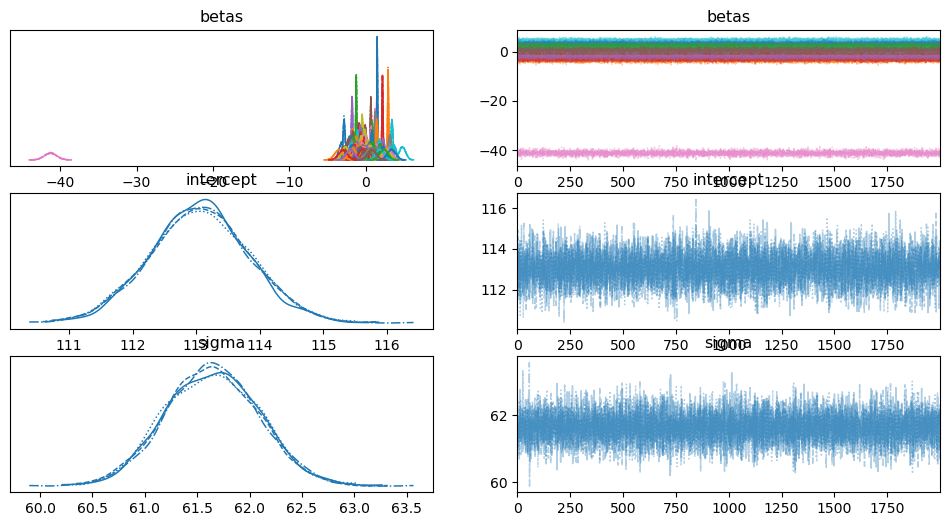

In [54]:
az.plot_trace(trace)

In [55]:
az.summary(trace)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
betas[PC1]             1.510  0.048    1.417    1.596      0.000    0.001   
betas[PC2]             2.943  0.066    2.816    3.062      0.001    0.001   
betas[PC3]            -1.229  0.067   -1.349   -1.099      0.000    0.001   
betas[PC4]             2.205  0.069    2.072    2.331      0.001    0.001   
betas[PC5]            -1.777  0.089   -1.948   -1.615      0.001    0.001   
...                      ...    ...      ...      ...        ...      ...   
betas[PC95]           -2.002  0.536   -2.983   -0.974      0.004    0.007   
betas[PC96]            0.820  0.538   -0.162    1.857      0.004    0.007   
betas[is_draftable]  -41.272  0.810  -42.852  -39.788      0.008    0.009   
intercept            113.053  0.779  111.545  114.474      0.008    0.008   
sigma                 61.643  0.442   60.799   62.436      0.004    0.005   

                     ess_bulk  ess_tail  r_hat  
betas[PC1]            16224.0    5572.0    1.0  
betas[PC2]            15720.0    5597.0    1.0  
betas[PC3]            19041.0    5745.0    1.0  
betas[PC4]            18274.0    5930.0    1.0  
betas[PC5]            19994.0    5810.0    1.0  
...                       ...       ...    ...  
betas[PC95]           17106.0    5716.0    1.0  
betas[PC96]           15758.0    5990.0    1.0  
betas[is_draftable]    9943.0    6718.0    1.0  
intercept              9680.0    6507.0    1.0  
sigma                 15483.0    6020.0    1.0  

[99 rows x 9 columns]

In [56]:
i = 132
x_pca_features = X_test_pca[i]

is_draftable_value = y_pred[i]

x_new_scaled = np.concatenate([x_pca_features, [is_draftable_value]])

print(projection_models_test.iloc[i])
print(y_test.iloc[i])

intercept_samples = trace.posterior["intercept"].values.flatten()
betas_samples = trace.posterior["betas"].values
sigma_samples = trace.posterior["sigma"].values.flatten()

n_chains, n_draws, n_features = betas_samples.shape
betas_samples = betas_samples.reshape(n_chains * n_draws, n_features)

n_samples = len(intercept_samples)

mu_samples = intercept_samples + np.dot(betas_samples, x_new_scaled)

posterior_pred_samples = np.random.normal(mu_samples, sigma_samples)

projected_median = np.median(posterior_pred_samples)
credible_interval_95 = np.percentile(posterior_pred_samples, [2.5, 97.5])
credible_interval_90 = np.percentile(posterior_pred_samples, [5, 95])
credible_interval_85 = np.percentile(posterior_pred_samples, [7.5, 92.5])
credible_interval_75 = np.percentile(posterior_pred_samples, [12.5, 87.5])
credible_interval_50 = np.percentile(posterior_pred_samples, [25, 75])
prob_gt_200 = np.mean(posterior_pred_samples > 200)

print(f"Projected season points (median): {projected_median:.1f}")
print(f"95% credible interval: [{credible_interval_95[0]:.1f}, {credible_interval_95[1]:.1f}]")
print(f"90% credible interval: [{credible_interval_90[0]:.1f}, {credible_interval_90[1]:.1f}]")
print(f"85% credible interval: [{credible_interval_85[0]:.1f}, {credible_interval_85[1]:.1f}]")
print(f"75% credible interval: [{credible_interval_75[0]:.1f}, {credible_interval_75[1]:.1f}]")
print(f"50% credible interval: [{credible_interval_50[0]:.1f}, {credible_interval_50[1]:.1f}]")
print(f"Probability points > 200: {prob_gt_200:.2%}")

season                                                2023
gsis_id                                         00-0033282
full_name_all_players                        Curtis Samuel
fantasy_pts                                          152.2
ff_pts_prev_year                                     175.9
years_exp                                              6.0
Rank                                                 240.0
ESPN                                                   NaN
AVG                                                  230.3
position_rank                                         78.0
injury_prone                                           1.0
team_change                                              0
reception_prev_season                                 63.0
passing_yards_prev_season                              0.0
pass_touchdown_prev_season                             0.0
rush_touchdown_prev_season                             1.0
interception_prev_season                               0

## EXTRA

In [97]:
X_train = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_test = projection_models_test[['fantasy_pts']]

In [98]:
print(X_test.columns)

Index(['position', 'ff_pts_prev_year', 'years_exp', 'Rank', 'ESPN', 'AVG',
       'position_rank', 'injury_prone', 'team_change', 'reception_prev_season',
       'passing_yards_prev_season', 'pass_touchdown_prev_season',
       'rush_touchdown_prev_season', 'interception_prev_season',
       'fumble_lost_prev_season', 'rushing_yards_prev_season',
       'two_pt_prev_season', 'receiving_yards_prev_season',
       'receive_touchdown_prev_season', 'ff_pts_diff_prev_season',
       'Rank_prev_season', 'ESPN_prev_season', 'AVG_prev_season',
       'position_rank_prev_season', 'position_season_end_rank_prev_season',
       'season_end_rank_prev_season',
       'position_season_end_rank_diff_prev_season',
       'season_end_rank_diff_prev_season', 'ESPN_reranked_prev_season',
       'ADP_diff_prev_season', 'injury_count_num_weeks_prev_season',
       'significant_injury_prev_season'],
      dtype='object')


In [99]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error

# Choosing XGBRegressor since it can handle nans
clf = XGBRegressor(enable_categorical=True, verbose=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_squared_error(y_test, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')

c:\Users\irela\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:06:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


r2: 0.5717278718948364
mse: 3443.693115234375
rmse: 58.682987213134766
mae: 3443.693115234375


In [6]:
import shap

def plot_feature_explainer(fitted_model, X_test, plot_type, model_type=None, i=None, feature_col_name=None):
    if model_type=='tree':
        explainer = shap.explainers.Tree(fitted_model)
    elif model_type=='linear':
        explainer = shap.explainers.Linear(fitted_model, X_test)
    else:
        raise ValueError("Please spedcify model type as 'linear' or 'tree'.")

    explanation = explainer(X_test)

    def waterfall_plot(i):
        shap.plots.waterfall(explanation[i])

    def force_plot(i):
        shap.plots.initjs()
        shap.plots.force(explanation[i])

    def global_predictions_plot(feature_col_name):
        shap.plots.scatter(explanation[:, feature_col_name], color=explanation)

    def beeswarm_plot():
        shap.plots.beeswarm(explanation)

    def avg_bar_plot():
        shap.plots.bar(explanation)

    if i is None and (plot_type == 'waterfall' or plot_type == 'force_plot'):
        raise ValueError('Must specify which feature i you want to plot.')
    else:
        if plot_type == 'waterfall':
            print('Plotting waterfall plot...')
            waterfall_plot(i)
        elif plot_type == 'force_plot':
            print('Plotting force plot...')
            force_plot(i)
        elif plot_type == 'global_predictions':
            print('Plotting global predictions plot...')
            global_predictions_plot(feature_col_name)
        elif plot_type == 'beeswarm':
            print('Plotting beeswarm plot...')
            beeswarm_plot()
        elif plot_type == 'avg_bar':
            print('Plotting average bar plot...')
            avg_bar_plot()
        else:
            raise ValueError("Error: plot_type must be 'waterfall', 'force_plot', 'global_predictions', 'beeswarm', or 'avg_bar'.")


Plotting waterfall plot...


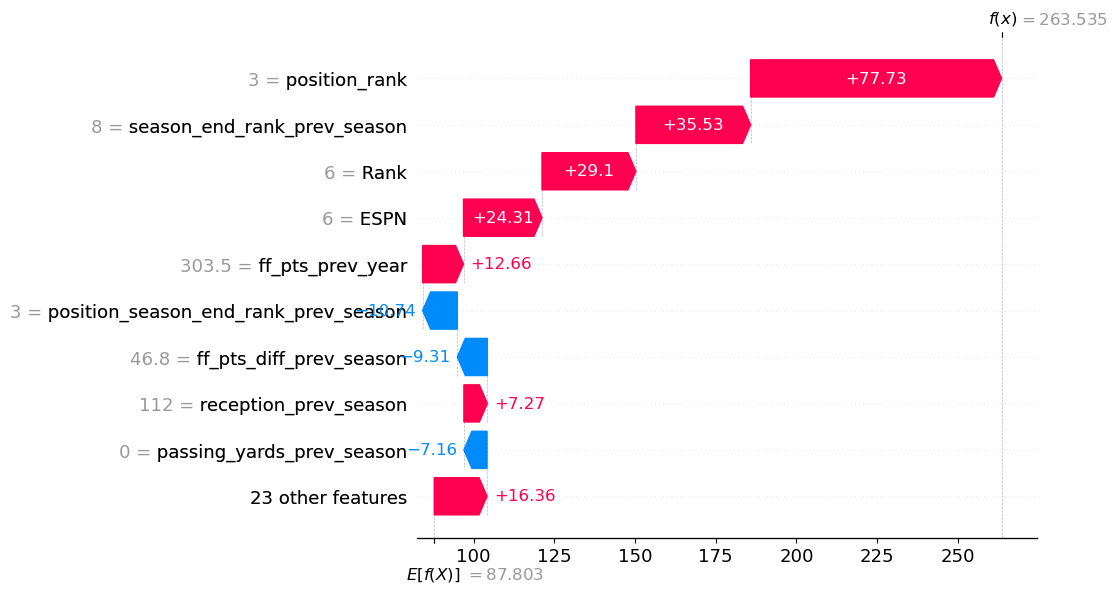

fantasy_pts    314.48
Name: 500, dtype: float64


In [7]:
i = 500
plot_feature_explainer(clf, X_test, plot_type='waterfall', model_type='tree', i=i)
print(y_test.iloc[i])

In [2]:
from quantile_forest import RandomForestQuantileRegressor
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

numeric_selector = make_column_selector(dtype_include="number")
categorical_selector = make_column_selector(dtype_include="object")

# preprocess numeric cols
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# preprocess categorical cols
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # sparse_output=False often easier
    ]
)
# apply numeric and categorical transformers
# Set remainder='passthrough' initially to catch unexpected columns
ct = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_selector),
        ("cat", categorical_transformer, categorical_selector),
    ],
    remainder="passthrough",  # Check if any columns are leftover
    verbose_feature_names_out=True,  # Keep feature names cleaner
)
# Define Pipeline
# chain workflow together
pipe = Pipeline(
    [
        ("ct", ct),
        #('poly', PolynomialFeatures(degree=2)),
        ("model",
            RandomForestQuantileRegressor(max_depth=3, min_samples_leaf=7, random_state=11)
        ),
    ]
)

In [46]:
projection_models_test['position'] = projection_models_test['position'].astype('object')
projection_models_train['position'] = projection_models_train['position'].astype('object')

X_train = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts']) # Try dropna before imputing?
y_test = projection_models_test[['fantasy_pts']]

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test, quantiles = [.25, .5, .75])

c:\Users\irela\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [47]:
y_test = y_test.iloc[:, 0]

results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Pred_05': y_pred[:, 0],
    'Pred_50': y_pred[:, 1],
    'Pred_95': y_pred[:, 2]
})

results_df['inside_interval'] = np.where(((results_df['Actual']>=results_df['Pred_05']) & (results_df['Actual']<=results_df['Pred_95'])), 1, 0)
results_df

Actual  Pred_05  Pred_50  Pred_95  inside_interval
0      0.00  145.200   207.54  258.725                0
1    231.62   86.775   141.75  221.200                0
2    100.84    4.100    19.70   61.850                0
3     84.48    7.575    39.77  131.600                1
4    243.10   86.775   141.75  221.200                0
..      ...      ...      ...      ...              ...
868    0.00    4.100    19.70   64.685                0
869    0.60    4.100    19.70   64.685                0
870  105.50   75.700   116.65  190.575                1
871   78.60    4.100    19.70   64.685                0
872   39.70    4.100    19.70   64.685                1

[873 rows x 5 columns]

In [48]:
print(results_df['inside_interval'].mean())

0.5693012600229095


In [12]:
fails = results_df[results_df['inside_interval']==0]
fails.head()

Actual  Pred_05  Pred_50  Pred_95  inside_interval
0     0.00   75.110   204.05  361.505                0
12   -2.86   -0.205    20.40  137.415                0
32   -0.30   -0.205    20.80  170.283                0
43   -0.20   -0.010    20.20  138.460                0
54    1.24    9.294   118.20  266.295                0

In [6]:
feature_stds = pd.get_dummies(X_train, columns=['position']).std().to_dict()
feature_stds

{'ff_pts_prev_year': 92.02202495220503,
 'years_exp': 3.320147686811346,
 'Rank': 183.14649040961964,
 'ESPN': 262.823375920457,
 'AVG': 164.40817239747753,
 'position_rank': 49.71644480022635,
 'injury_prone': 0.4154828274056646,
 'team_change': 0.49796625852650817,
 'reception_prev_season': 26.912655393493377,
 'passing_yards_prev_season': 1019.6852976806566,
 'pass_touchdown_prev_season': 6.803671467723698,
 'rush_touchdown_prev_season': 2.363385039840487,
 'interception_prev_season': 3.4522898664154504,
 'fumble_lost_prev_season': 1.1579457996931777,
 'rushing_yards_prev_season': 283.1379150445878,
 'two_pt_prev_season': 0.5515452304138926,
 'receiving_yards_prev_season': 347.44709751305396,
 'receive_touchdown_prev_season': 2.6025530845948297,
 'ff_pts_diff_prev_season': 74.37121825190542,
 'Rank_prev_season': 181.418511233719,
 'ESPN_prev_season': 268.8765947106798,
 'AVG_prev_season': 164.16636376588067,
 'position_rank_prev_season': 48.747070613549866,
 'position_season_end_ran

In [10]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

X_train_dummies = pd.get_dummies(X_train, columns=['position'])

model = RandomForestRegressor()
model.fit(X_train_dummies, y_train)

i = 405
base_input = X_train.iloc[i:i+1].copy() 
base_input_dummies = pd.get_dummies(base_input, columns=['position'])

base_input_dummies = base_input_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)

n_simulations = 1000
simulated_preds = []

for _ in tqdm(range(n_simulations)):
    noisy_input = base_input_dummies.copy()
    for feat in feature_stds:
        if feat in noisy_input.columns:
            noisy_input[feat] += np.random.normal(0, feature_stds[feat])
    y_pred = model.predict(noisy_input)[0]
    simulated_preds.append(y_pred)

simulated_preds = np.array(simulated_preds)
mean = np.mean(simulated_preds)
std = np.std(simulated_preds)
ci_05 = np.percentile(simulated_preds, 5)
ci_95 = np.percentile(simulated_preds, 95)

print(f"Predicted Fantasy Points: {mean:.2f} ± {std:.2f}")
print(f"90% CI: ({ci_05:.2f}, {ci_95:.2f})")
print(y_test.iloc[i])

c:\Users\irela\anaconda3\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 1000/1000 [00:31<00:00, 32.22it/s]

Predicted Fantasy Points: 131.36 ± 44.96
90% CI: (64.44, 208.06)
fantasy_pts    73.0
Name: 405, dtype: float64


In [4]:
import pymc as pm
from sklearn.impute import KNNImputer

projection_models_test['position'] = projection_models_test['position'].astype('object')
projection_models_train['position'] = projection_models_train['position'].astype('object')

projection_models_test = pd.get_dummies(projection_models_test, columns=['position'])
projection_models_train = pd.get_dummies(projection_models_train, columns=['position'])

X_train = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_test = projection_models_test[['fantasy_pts']]

imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [5]:
df = pd.DataFrame(X_train_scaled)
df["target"] = y_train.values

df_clean = df.dropna()

X_pm_train = df_clean.drop("target", axis=1).values
y_pm_train = df_clean["target"].values

basic_model = pm.Model()

feature_names = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts']).columns.to_list()

with pm.Model(coords={"features": feature_names}) as model:
    X_data = pm.Data("X_data", X_pm_train, dims=("obs", "features"))
    y_data = pm.Data("y_data", y_pm_train, dims="obs")
    
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=1, dims="features")
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pm.math.dot(X_data, betas)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data, dims="obs")

    trace = pm.sample(draws=500, tune=500, chains=1, cores=1, target_accept=0.9, random_seed=11)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [intercept, betas, sigma]


Output()

c:\Users\irela\anaconda3\Lib\site-packages\pytensor\scalar\basic.py:3191: RuntimeWarning: overflow encountered in 
exp
  return np.exp(x)

c:\Users\irela\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered 
in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 12506 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
import pickle

filepath = "../data/player_projections/trace_05_28.pkl"

with open(filepath, "wb") as f:
    pickle.dump(trace, f)

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

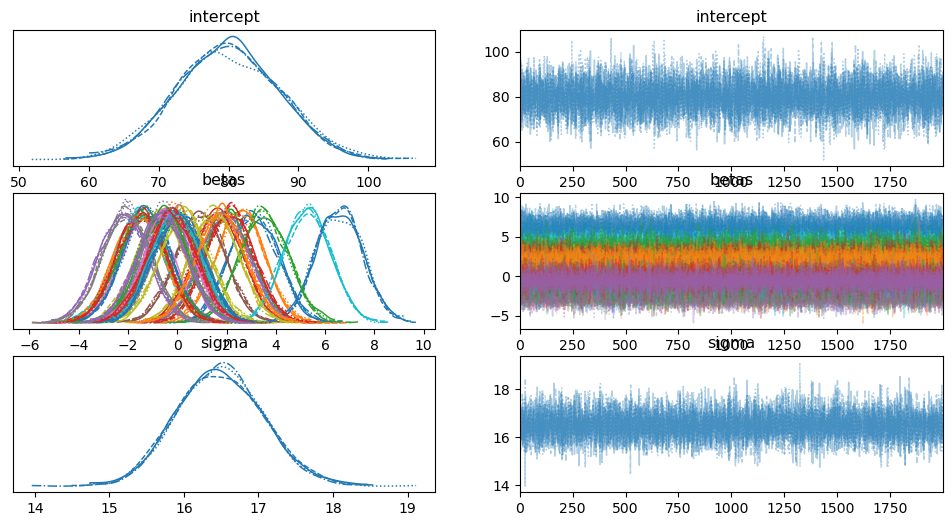

In [ ]:
import arviz as az

az.plot_trace(trace)

In [ ]:
az.summary(trace)

mean     sd  hdi_3%  \
intercept                                         79.921  7.399  66.449   
betas[ff_pts_prev_year]                            3.107  0.992   1.219   
betas[years_exp]                                   2.554  0.979   0.757   
betas[Rank]                                        2.022  1.000   0.146   
betas[ESPN]                                        1.677  0.982  -0.202   
betas[AVG]                                         1.929  1.002   0.021   
betas[position_rank]                               0.940  1.006  -0.964   
betas[injury_prone]                               -1.279  1.008  -3.169   
betas[team_change]                                 0.078  0.998  -1.769   
betas[reception_prev_season]                      -0.656  1.016  -2.571   
betas[passing_yards_prev_season]                   5.275  0.951   3.413   
betas[pass_touchdown_prev_season]                  6.576  0.942   4.849   
betas[rush_touchdown_prev_season]                 -0.223  0.972  -1.955   
betas[interception_prev_season]                    3.517  0.983   1.775   
betas[fumble_lost_prev_season]                     2.157  0.979   0.335   
betas[rushing_yards_prev_season]                  -0.342  0.994  -2.157   
betas[two_pt_prev_season]                         -0.141  1.003  -1.986   
betas[receiving_yards_prev_season]                -0.603  0.986  -2.472   
betas[receive_touchdown_prev_season]              -0.472  0.984  -2.307   
betas[ff_pts_diff_prev_season]                     1.505  0.976  -0.304   
betas[Rank_prev_season]                           -1.560  1.010  -3.402   
betas[ESPN_prev_season]                           -1.234  0.982  -3.174   
betas[AVG_prev_season]                            -1.535  1.020  -3.377   
betas[position_rank_prev_season]                  -1.400  1.007  -3.280   
betas[position_season_end_rank_prev_season]       -1.449  0.996  -3.339   
betas[season_end_rank_prev_season]                -2.171  0.982  -4.042   
betas[position_season_end_rank_diff_prev_season]  -0.118  1.007  -2.022   
betas[season_end_rank_diff_prev_season]           -0.307  1.009  -2.274   
betas[ESPN_reranked_prev_season]                  -2.043  0.981  -3.898   
betas[ADP_diff_prev_season]                        0.306  1.006  -1.531   
betas[injury_count_num_weeks_prev_season]         -0.065  0.973  -1.780   
betas[significant_injury_prev_season]              0.059  0.991  -1.750   
betas[position_QB]                                 1.772  1.002  -0.090   
betas[position_RB]                                -0.577  1.014  -2.480   
betas[position_TE]                                -0.254  0.992  -2.137   
betas[position_WR]                                -0.630  0.997  -2.480   
sigma                                             16.491  0.577  15.403   

                                                  hdi_97%  mcse_mean  mcse_sd  \
intercept                                          94.123      0.060    0.083   
betas[ff_pts_prev_year]                             4.904      0.007    0.014   
betas[years_exp]                                    4.439      0.007    0.014   
betas[Rank]                                         3.907      0.007    0.014   
betas[ESPN]                                         3.453      0.007    0.012   
betas[AVG]                                          3.786      0.007    0.013   
betas[position_rank]                                2.768      0.007    0.013   
betas[injury_prone]                                 0.614      0.007    0.013   
betas[team_change]                                  1.945      0.007    0.013   
betas[reception_prev_season]                        1.267      0.007    0.014   
betas[passing_yards_prev_season]                    6.969      0.007    0.012   
betas[pass_touchdown_prev_season]                   8.378      0.007    0.011   
betas[rush_touchdown_prev_season]                   1.707      0.007    0.012   
betas[interception_prev_season]                     5.445      0.00

In [37]:
print(X_test.columns.to_list())

['ff_pts_prev_year', 'years_exp', 'Rank', 'ESPN', 'AVG', 'position_rank', 'injury_prone', 'team_change', 'reception_prev_season', 'passing_yards_prev_season', 'pass_touchdown_prev_season', 'rush_touchdown_prev_season', 'interception_prev_season', 'fumble_lost_prev_season', 'rushing_yards_prev_season', 'two_pt_prev_season', 'receiving_yards_prev_season', 'receive_touchdown_prev_season', 'ff_pts_diff_prev_season', 'Rank_prev_season', 'ESPN_prev_season', 'AVG_prev_season', 'position_rank_prev_season', 'position_season_end_rank_prev_season', 'season_end_rank_prev_season', 'position_season_end_rank_diff_prev_season', 'season_end_rank_diff_prev_season', 'ESPN_reranked_prev_season', 'ADP_diff_prev_season', 'injury_count_num_weeks_prev_season', 'significant_injury_prev_season']


In [ ]:
i = 161
x_new_scaled = np.array(X_test_scaled[i])
print(projection_models_test.iloc[i])
print(y_test.iloc[i])

season                                             2023
gsis_id                                      00-0034857
full_name_all_players                        Josh Allen
fantasy_pts                                      369.58
ff_pts_prev_year                                 373.76
years_exp                                           5.0
Rank                                               21.0
ESPN                                               20.0
AVG                                                20.5
position_rank                                       2.0
injury_prone                                        1.0
team_change                                           0
reception_prev_season                               0.0
passing_yards_prev_season                        4029.0
pass_touchdown_prev_season                         32.0
rush_touchdown_prev_season                          7.0
interception_prev_season                           13.0
fumble_lost_prev_season                         

In [ ]:
intercept_samples = trace.posterior["intercept"].values.flatten()
betas_samples = trace.posterior["betas"].values
sigma_samples = trace.posterior["sigma"].values.flatten()

n_chains, n_draws, n_features = betas_samples.shape
betas_samples = betas_samples.reshape(n_chains * n_draws, n_features)

n_samples = len(intercept_samples)

mu_samples = intercept_samples + np.dot(betas_samples, x_new_scaled)


posterior_pred_samples = np.random.normal(mu_samples, sigma_samples)

projected_median = np.median(posterior_pred_samples)
credible_interval = np.percentile(posterior_pred_samples, [2.5, 97.5])
prob_gt_200 = np.mean(posterior_pred_samples > 200)

print(f"Projected season points (median): {projected_median:.1f}")
print(f"95% credible interval: [{credible_interval[0]:.1f}, {credible_interval[1]:.1f}]")
print(f"Probability points > 200: {prob_gt_200:.2%}")


Projected season points (median): 175.2
95% credible interval: [136.2, 213.3]
Probability points > 200: 9.86%


In [ ]:
"""
with basic_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train_scaled.shape[1])
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pm.math.dot(X_train_scaled, betas)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    trace = pm.sample(2000, tune=1000, target_accept=0.9)
"""

In [ ]:
import arviz as az

intercepts = trace.posterior['intercept'].stack(samples=('chain', 'draw')).values
betas = trace.posterior['betas'].stack(samples=('chain', 'draw')).values

preds = []
for i in range(len(intercepts)):
    pred = intercepts[i] + np.dot(X_test_scaled, betas[:, i])
    preds.append(pred)

preds = np.array(preds)

mean_preds = preds.mean(axis=0)
hdi_preds = az.hdi(preds.T, hdi_prob=0.95)

In [ ]:
r2 = r2_score(y_test, mean_preds)
mse = mean_squared_error(y_test, mean_preds)
rmse = root_mean_squared_error(y_test, mean_preds)
mae = mean_squared_error(y_test, mean_preds)

print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test)), mean_preds, 
             yerr=[mean_preds - hdi_preds[:, 0], hdi_preds[:, 1] - mean_preds],
             fmt='o', label='Predicted Fantasy Points ±95% HDI')
plt.plot(y_test.values, 'x', label='Actual Fantasy Points', color='red')
plt.legend()
plt.title("Bayesian Prediction vs. Actual on Test Set")
plt.xlabel("Test Sample Index")
plt.ylabel("Fantasy Points")
plt.show()

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer

numeric_selector = make_column_selector(dtype_include="number")
categorical_selector = make_column_selector(dtype_include="object")

# preprocess numeric cols
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# preprocess categorical cols
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # sparse_output=False often easier
    ]
)
# apply numeric and categorical transformers
# Set remainder='passthrough' initially to catch unexpected columns
ct = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_selector),
        ("cat", categorical_transformer, categorical_selector),
    ],
    remainder="passthrough",  # Check if any columns are leftover
    verbose_feature_names_out=True,  # Keep feature names cleaner
)
# Define Pipeline
# chain workflow together
pipe = Pipeline(
    [
        ("ct", ct),
        #('poly', PolynomialFeatures(degree=3)),
        ("model",
            LGBMRegressor()
        ),
    ]
)

In [ ]:
projection_models_test['position'] = projection_models_test['position'].astype('object')
projection_models_train['position'] = projection_models_train['position'].astype('object')

X_train = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts']) # Try dropna before imputing?
y_test = projection_models_test[['fantasy_pts']]

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_squared_error(y_test, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')

r2: 0.6116102410351474
mse: 3123.0029711435604
rmse: 55.88383461380903
mae: 3123.0029711435604


c:\Users\irela\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\irela\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


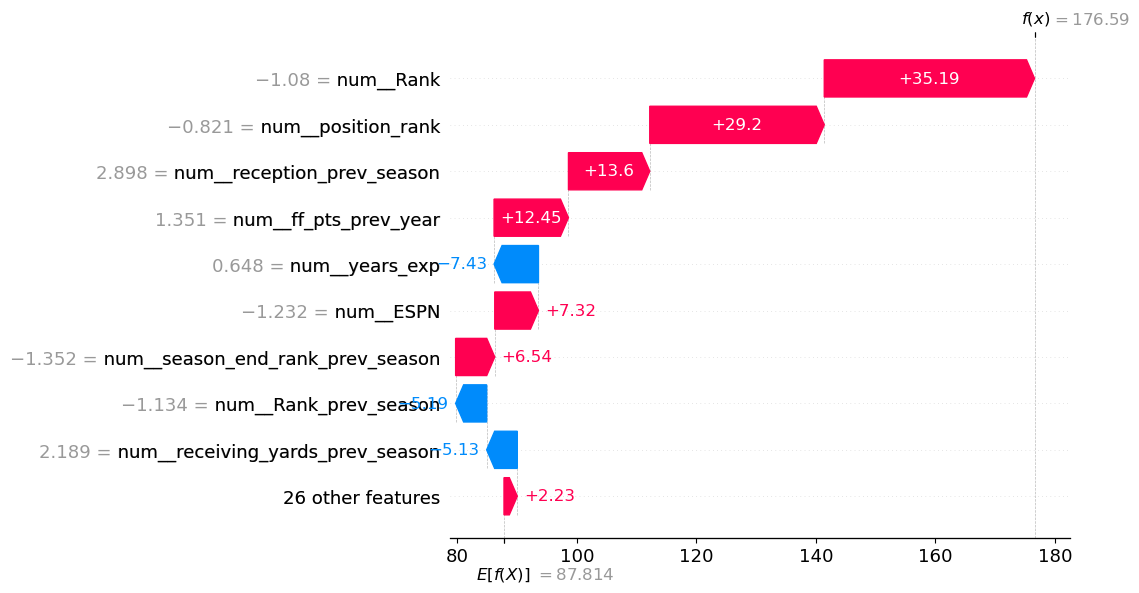

fantasy_pts    197.7
Name: 302, dtype: float64


In [ ]:
pre_pipe = Pipeline([('ct', ct)])
X_test_transformed = pre_pipe.fit_transform(X_test)
feature_names = pre_pipe.named_steps['ct'].get_feature_names_out()
explainer = shap.Explainer(pipe.named_steps["model"])
explanation = explainer(X_test_transformed)
explanation.feature_names = feature_names

i=302

shap.plots.waterfall(explanation[i])
print(y_test.iloc[i])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_selector = make_column_selector(dtype_include="number")
categorical_selector = make_column_selector(dtype_include="object")

# preprocess numeric cols
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# preprocess categorical cols
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # sparse_output=False often easier
    ]
)



# Preprocessing pipeline
preprocessor =  ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_selector),
        ("cat", categorical_transformer, categorical_selector),
    ],
    remainder="passthrough",  # Check if any columns are leftover
    verbose_feature_names_out=True,  # Keep feature names cleaner
)

# Ensemble (stacking) of models
estimators = [
    ('rf', RandomForestRegressor()),
    ('ridge', Ridge())
]

stacking_reg = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# Full pipeline: preprocess then ensemble
pipe = Pipeline([
    ('preproc', preprocessor),
    ('ensemble', stacking_reg)
])



In [ ]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_squared_error(y_test, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')

c:\Users\irela\anaconda3\Lib\site-packages\sklearn\ensemble\_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


r2: 0.6096273325179319
mse: 3138.9473390055628
rmse: 56.02630934664145
mae: 3138.9473390055628


In [ ]:
from sklearn.neural_network import MLPRegressor

numeric_selector = make_column_selector(dtype_include="number")
categorical_selector = make_column_selector(dtype_include="object")

# preprocess numeric cols
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# preprocess categorical cols
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # sparse_output=False often easier
    ]
)
# apply numeric and categorical transformers
# Set remainder='passthrough' initially to catch unexpected columns
ct = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_selector),
        ("cat", categorical_transformer, categorical_selector),
    ],
    remainder="passthrough",  # Check if any columns are leftover
    verbose_feature_names_out=True,  # Keep feature names cleaner
)
# Define Pipeline
# chain workflow together
pipe = Pipeline(
    [
        ("ct", ct),
        ('poly', PolynomialFeatures(degree=3)),
        ("model",
            XGBRegressor()
        ),
    ]
)

In [ ]:
projection_models_test['position'] = projection_models_test['position'].astype('object')
projection_models_train['position'] = projection_models_train['position'].astype('object')

X_train = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts']) # Try dropna before imputing?
y_test = projection_models_test[['fantasy_pts']]

In [ ]:
# Choosing XGBRegressor since it can handle nans
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_squared_error(y_test, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')

r2: 0.5619162917137146
mse: 3522.587158203125
rmse: 59.35138702392578
mae: 3522.587158203125


In [ ]:
pre_pipe = Pipeline([
    ("ct", ct),
    ("poly", PolynomialFeatures(degree=3, include_bias=False))
])

pre_pipe.fit(X_train)

ct_feature_names = pre_pipe.named_steps["ct"].get_feature_names_out()

poly = pre_pipe.named_steps["poly"]
final_feature_names = poly.get_feature_names_out(ct_feature_names)

print(final_feature_names)

['num__ff_pts_prev_year' 'num__years_exp' 'num__Rank' ...
 'cat__position_TE^2 cat__position_WR'
 'cat__position_TE cat__position_WR^2' 'cat__position_WR^3']


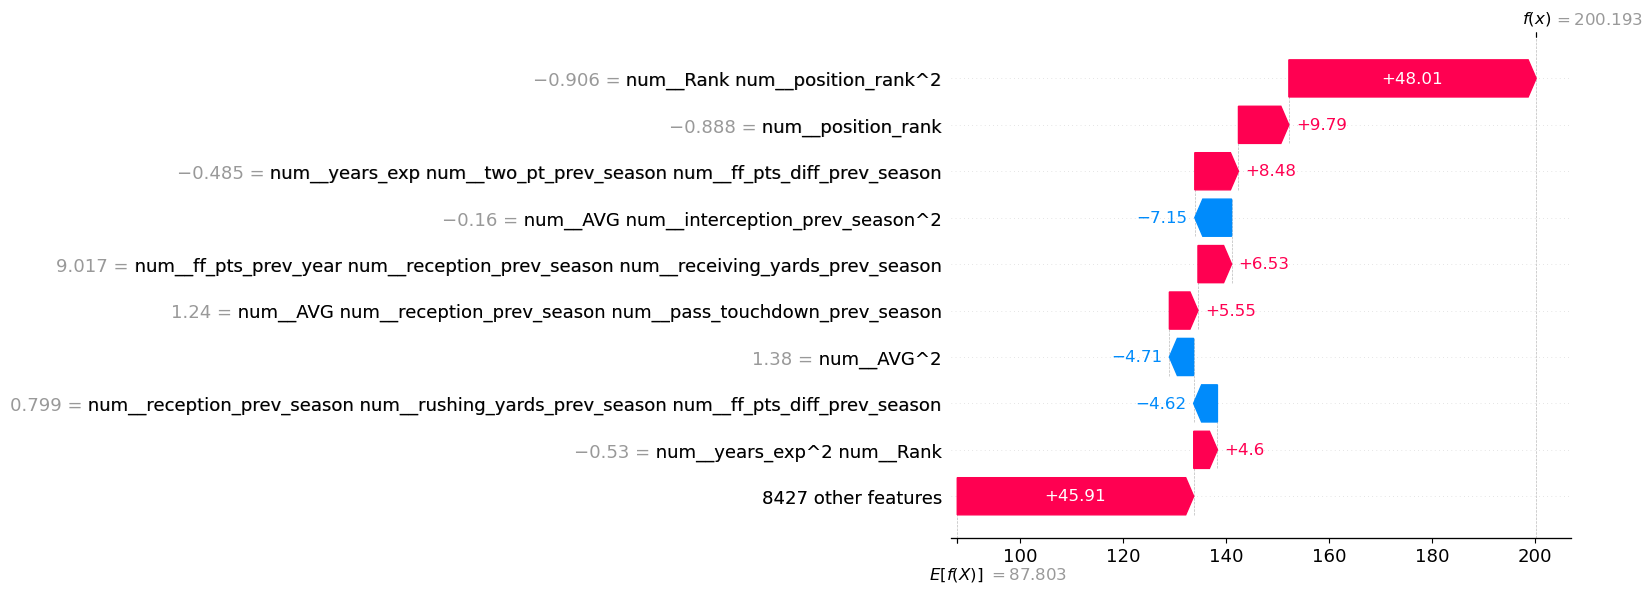

fantasy_pts    197.7
Name: 302, dtype: float64


In [ ]:
pipe.fit(X_train, y_train)
preprocessing_pipe = pipe[:-1]

X_transformed = preprocessing_pipe.transform(X_test)

ct_feature_names = pipe.named_steps['ct'].get_feature_names_out()
poly = pipe.named_steps['poly']
final_feature_names = poly.get_feature_names_out(ct_feature_names)

explainer = shap.Explainer(pipe.named_steps["model"])
explanation = explainer(X_transformed)
explanation.feature_names = final_feature_names

i=302

shap.plots.waterfall(explanation[i])
print(y_test.iloc[i])

In [ ]:
from sklearn.neural_network import MLPRegressor

numeric_selector = make_column_selector(dtype_include="number")
categorical_selector = make_column_selector(dtype_include="object")

# preprocess numeric cols
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# preprocess categorical cols
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),  # sparse_output=False often easier
    ]
)
# apply numeric and categorical transformers
# Set remainder='passthrough' initially to catch unexpected columns
ct = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_selector),
        ("cat", categorical_transformer, categorical_selector),
    ],
    remainder="passthrough",  # Check if any columns are leftover
    verbose_feature_names_out=True,  # Keep feature names cleaner
)
# Define Pipeline
# chain workflow together
pipe = Pipeline(
    [
        ("ct", ct),
        #('poly', PolynomialFeatures(degree=3)),
        ("model",
            MLPRegressor(hidden_layer_sizes=(32, 16, 8, 4))
        ),
    ]
)


In [ ]:
projection_models_test['position'] = projection_models_test['position'].astype('object')
projection_models_train['position'] = projection_models_train['position'].astype('object')

X_train = projection_models_train.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts'])
y_train = projection_models_train[['fantasy_pts']]
X_test = projection_models_test.drop(columns=['season','gsis_id', 'full_name_all_players', 'fantasy_pts']) # Try dropna before imputing?
y_test = projection_models_test[['fantasy_pts']]

# Choosing XGBRegressor since it can handle nans
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_squared_error(y_test, y_pred)

print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')

r2: 0.5619162917137146
mse: 3522.587158203125
rmse: 59.35138702392578
mae: 3522.587158203125


### Expanding Josh Allen's stats

In [ ]:
ja = all_players[all_players['id']==josh_allen_id]
ja

season  reception  passing_yards  pass_touchdown  rush_touchdown  \
10453    2018          0         2044.0            10.0             8.0   
10454    2019          0         3089.0            20.0             9.0   
10455    2020          1         4544.0            37.0             8.0   
10456    2021          0         4168.0            34.0             6.0   
10457    2022          0         4029.0            32.0             7.0   
10458    2023          0         3947.0            27.0            15.0   
10459    2024          0         3731.0            28.0            12.0   

       interception  fumble_lost  rushing_yards  two_pt  receiving_yards  ...  \
10453          12.0          2.0          631.0     1.0              0.0  ...   
10454           9.0          4.0          510.0     3.0              0.0  ...   
10455          10.0          6.0          421.0     0.0             12.0  ...   
10456          15.0          3.0          700.0     3.0              0.0  ...   
10457          13.0          5.0          746.0     2.0              0.0  ...   
10458          16.0          3.0          457.0     3.0              0.0  ...   
10459           6.0          2.0          531.0     1.0              0.0  ...   

       height weight  college     gsis_id years_exp  \
10453    77.0  240.0  Wyoming  00-0034857       0.0   
10454    77.0  237.0  Wyoming  00-0034857       1.0   
10455    77.0  237.0  Wyoming  00-0034857       2.0   
10456    77.0  237.0  Wyoming  00-0034857       3.0   
10457    77.0  237.0  Wyoming  00-0034857       4.0   
10458    77.0  237.0  Wyoming  00-0034857       5.0   
10459    77.0  237.0  Wyoming  00-0034857       6.0   

                                            headshot_url  rookie_year  \
10453  https://static.www.nfl.com/image/private/f_aut...       2018.0   
10454  https://static.www.nfl.com/image/private/f_aut...       2018.0   
10455  https://static.www.nfl.com/image/private/f_aut...       2018.0   
10456  https://static.www.nfl.com/image/private/f_aut...       2018.0   
10457  https://static.www.nfl.com/image/private/f_aut...       2018.0   
10458  https://static.www.nfl.com/image/private/f_aut...       2018.0   
10459  https://static.www.nfl.com/image/upload/f_auto...       2018.0   

      ff_pts_prev_year ff_pts_diff   merge_key  
10453              NaN         NaN  josh allen  
10454           206.86       81.70  josh allen  
10455           288.56      107.50  josh allen  
10456           396.06      -17.34  josh allen  
10457           378.72       -4.96  josh allen  
10458           373.76       -4.18  josh allen  
10459           369.58        2.76  josh allen  

[7 rows x 32 columns]

In [ ]:
ja_df = pd.merge(ja, rosters, how='left', left_on=['id', 'season'], right_on=['gsis_id', 'season'])
ja_df

season  reception  passing_yards  pass_touchdown  rush_touchdown  \
0    2018          0         2044.0            10.0             8.0   
1    2019          0         3089.0            20.0             9.0   
2    2020          1         4544.0            37.0             8.0   
3    2021          0         4168.0            34.0             6.0   
4    2022          0         4029.0            32.0             7.0   
5    2023          0         3947.0            27.0            15.0   
6    2024          0         3731.0            28.0            12.0   

   interception  fumble_lost  rushing_yards  two_pt  receiving_yards  ...  \
0          12.0          2.0          631.0     1.0              0.0  ...   
1           9.0          4.0          510.0     3.0              0.0  ...   
2          10.0          6.0          421.0     0.0             12.0  ...   
3          15.0          3.0          700.0     3.0              0.0  ...   
4          13.0          5.0          746.0     2.0              0.0  ...   
5          16.0          3.0          457.0     3.0              0.0  ...   
6           6.0          2.0          531.0     1.0              0.0  ...   

                               smart_id entry_year  rookie_year_y draft_club  \
0  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   
1  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   
2  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   
3  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   
4  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   
5  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   
6  3200414c-4c52-9264-bedc-c4ddaf201fe7     2018.0         2018.0        BUF   

  ngs_position  week  game_type status_description_abbr football_name  \
0           QB  17.0        REG                     A01          Josh   
1           QB  18.0         WC                     A01          Josh   
2           QB  20.0        CON                     A01          Josh   
3           QB  20.0        DIV                     A01          Josh   
4           QB  20.0        DIV                     A01          Josh   
5           QB  20.0        DIV                     A01          Josh   
6           QB  21.0        CON                     A01          Josh   

  draft_number  
0          7.0  
1          7.0  
2          7.0  
3          7.0  
4          7.0  
5          7.0  
6          7.0  

[7 rows x 67 columns]

In [ ]:
next_gen_pass = pd.read_csv('../data/raw/next_gen_passing.csv', index_col=0).reset_index(drop=True)
next_gen_pass.head()

season season_type  week player_display_name player_position team_abbr  \
0    2016         REG     0          Drew Brees              QB        NO   
1    2016         REG     0          Joe Flacco              QB       BAL   
2    2016         REG     0      Russell Wilson              QB       SEA   
3    2016         REG     0         Josh McCown              QB       CLE   
4    2016         REG     0         Eli Manning              QB       NYG   

   avg_time_to_throw  avg_completed_air_yards  avg_intended_air_yards  \
0           2.424238                 6.195456                7.550997   
1           2.566823                 5.187294                7.720937   
2           2.606104                 7.167756                9.240646   
3           2.800770                 7.360889               10.353818   
4           2.527473                 5.437374                8.191990   

   avg_air_yards_differential  ...  completion_percentage  \
0                   -1.355541  ...              69.985141   
1                   -2.533644  ...              64.880952   
2                   -2.072890  ...              64.652015   
3                   -2.992929  ...              54.545455   
4                   -2.754616  ...              63.043478   

   expected_completion_percentage  completion_percentage_above_expectation  \
0                       64.783965                                 5.201176   
1                       64.367218                                 0.513734   
2                       59.305514                                 5.346501   
3                       59.587162                                -5.041707   
4                       63.397823                                -0.354345   

   avg_air_distance  max_air_distance  player_gsis_id  player_first_name  \
0         20.815996         59.033016      00-0020531               Drew   
1         20.995448         62.710625      00-0026158                Joe   
2         23.137055         61.277761      00-0029263            Russell   
3         23.423919         55.424624      00-0021206               Josh   
4         20.702627         57.601267      00-0022803                Eli   

   player_last_name  player_jersey_number  player_short_name  
0             Brees                     9            D.Brees  
1            Flacco                     5           J.Flacco  
2            Wilson                     3           R.Wilson  
3            McCown                    13                NaN  
4           Manning                    10          E.Manning  

[5 rows x 29 columns]

In [ ]:
ja_ng = next_gen_pass[next_gen_pass['player_gsis_id']==josh_allen_id]
ja_ng.head()

season season_type  week player_display_name player_position team_abbr  \
1173    2018         REG     0          Josh Allen              QB       BUF   
1201    2018         REG     1          Josh Allen              QB       BUF   
1241    2018         REG     2          Josh Allen              QB       BUF   
1266    2018         REG     3          Josh Allen              QB       BUF   
1308    2018         REG     4          Josh Allen              QB       BUF   

      avg_time_to_throw  avg_completed_air_yards  avg_intended_air_yards  \
1173           3.217784                 6.478698               11.029344   
1201           3.724800                11.066667               15.266667   
1241           3.504394                 7.142222               10.744545   
1266           2.699636                 3.708667                8.293182   
1308           3.013848                 4.710625                9.206061   

      avg_air_yards_differential  ...  completion_percentage  \
1173                   -4.550646  ...              52.812500   
1201                   -4.200000  ...              40.000000   
1241                   -3.602323  ...              54.545455   
1266                   -4.584515  ...              68.181818   
1308                   -4.495436  ...              48.484848   

      expected_completion_percentage  completion_percentage_above_expectation  \
1173                       60.919193                                -8.106693   
1201                       48.891475                                -8.891475   
1241                       63.544038                                -8.998583   
1266                       64.890220                                 3.291598   
1308                       64.934962                               -16.450113   

      avg_air_distance  max_air_distance  player_gsis_id  player_first_name  \
1173         23.969448         67.257523      00-0034857             Joshua   
1201         27.437653         48.794920      00-0034857             Joshua   
1241         23.379660         63.935646      00-0034857             Joshua   
1266         20.755469         52.429551      00-0034857             Joshua   
1308         24.352180         57.575886      00-0034857             Joshua   

      player_last_name  player_jersey_number  player_short_name  
1173             Allen                    17            J.Allen  
1201             Allen                    17            J.Allen  
1241             Allen                    17            J.Allen  
1266             Allen                    17            J.Allen  
1308             Allen                    17            J.Allen  

[5 rows x 29 columns]

In [ ]:
ja_ng_filtered = ja_ng[ja_ng['week']<18]
ja_ng_grouped = ja_ng_filtered.groupby('season').agg({'player_position':'first',
                                                      'team_abbr':'first',
                                                      'avg_time_to_throw':'mean',
                                                      'avg_completed_air_yards':'mean',
                                                      'avg_intended_air_yards':'mean',
                                                      'avg_air_yards_differential':'mean',
                                                      'aggressiveness':'mean',
                                                        # More to add...
                                                      })
ja_ng_grouped

player_position team_abbr  avg_time_to_throw  avg_completed_air_yards  \
season                                                                         
2018                QB       BUF           3.217519                 6.671415   
2019                QB       BUF           2.851657                 6.486776   
2020                QB       BUF           3.045675                 6.904674   
2021                QB       BUF           2.919952                 6.954294   
2022                QB       BUF           2.856187                 7.453386   
2023                QB       BUF           2.890902                 5.936266   
2024                QB       BUF           2.892080                 5.383275   

        avg_intended_air_yards  avg_air_yards_differential  aggressiveness  
season                                                                      
2018                 11.151912                   -4.480497       14.229480  
2019                  9.481988                   -2.995211       15.239672  
2020                  8.833025                   -1.928351       13.308553  
2021                  8.837729                   -1.883435       11.936116  
2022                  9.359086                   -1.905700       12.621350  
2023                  8.551637                   -2.615371       14.445016  
2024                  8.326768                   -2.943493       17.051663

In [ ]:
ja_df = pd.merge(ja_df, next_gen_pass, how='left', left_on=['id', 'season'], right_on=['player_gsis_id', 'season'])
ja_df

season  reception  passing_yards  pass_touchdown  rush_touchdown  \
0      2018          0         2044.0            10.0             8.0   
1      2018          0         2044.0            10.0             8.0   
2      2018          0         2044.0            10.0             8.0   
3      2018          0         2044.0            10.0             8.0   
4      2018          0         2044.0            10.0             8.0   
..      ...        ...            ...             ...             ...   
124    2024          0         3731.0            28.0            12.0   
125    2024          0         3731.0            28.0            12.0   
126    2024          0         3731.0            28.0            12.0   
127    2024          0         3731.0            28.0            12.0   
128    2024          0         3731.0            28.0            12.0   

     interception  fumble_lost  rushing_yards  two_pt  receiving_yards  ...  \
0            12.0          2.0          631.0     1.0              0.0  ...   
1            12.0          2.0          631.0     1.0              0.0  ...   
2            12.0          2.0          631.0     1.0              0.0  ...   
3            12.0          2.0          631.0     1.0              0.0  ...   
4            12.0          2.0          631.0     1.0              0.0  ...   
..            ...          ...            ...     ...              ...  ...   
124           6.0          2.0          531.0     1.0              0.0  ...   
125           6.0          2.0          531.0     1.0              0.0  ...   
126           6.0          2.0          531.0     1.0              0.0  ...   
127           6.0          2.0          531.0     1.0              0.0  ...   
128           6.0          2.0          531.0     1.0              0.0  ...   

     completion_percentage expected_completion_percentage  \
0                52.812500                      60.919193   
1                40.000000                      48.891475   
2                54.545455                      63.544038   
3                68.181818                      64.890220   
4                48.484848                      64.934962   
..                     ...                            ...   
124              55.172414                      56.745687   
125              59.259259                      57.271931   
126              76.923077                      64.237265   
127              72.727273                      74.503033   
128              64.705882                      65.173744   

     completion_percentage_above_expectation avg_air_distance  \
0                                  -8.106693        23.969448   
1                                  -8.891475        27.437653   
2                                  -8.998583        23.379660   
3                                   3.291598        20.755469   
4                                 -16.450113        24.352180   
..                                       ...              ...   
124                                -1.573274        24.757465   
125                                 1.987328        20.651440   
126                                12.685812        21.267522   
127                                -1.775760        18.502121   
128                                -0.467862        20.560432   

    max_air_distance player_gsis_id  player_first_name player_last_name  \
0          67.257523     00-0034857             Joshua            Allen   
1          48.794920     00-0034857             Joshua            Allen   
2          63.935646     00-0034857             Joshua            Allen   
3          52.429551     00-0034857             Joshua            Allen   
4          57.575886     00-0034857             Joshua            Allen   
..               ...            ...                ...              ...   
124        60.458993     00-0034857             Joshua            Allen   
125        45.627335     00-0034857             Joshua           